# PREDICT PRODUCT DEMAND - REGRESSION

The aim of this project is to understand the performance of an e-commerce store and predict the demand of products.

##  About Dataset
This dataset provides an in-depth look at the profitability of e-commerce sales. It contains data on a variety of sales channels, including Shiprocket and INCREFF, as well as financial information on related expenses and profits. The columns contain data such as SKU codes, design numbers, stock levels, product categories, sizes and colors. In addition to this we have included the MRPs across multiple stores like Ajio MRP , Amazon MRP , Amazon FBA MRP , Flipkart MRP , Limeroad MRP Myntra MRP and PaytmMRP along with other key parameters like amount paid by customer for the purchase , rate per piece for every individual transaction Also we have added transactional parameters like Date of sale months category fulfilledby B2b Status Qty Currency Gross amt . This is a must-have dataset for anyone trying to uncover the profitability of e-commerce sales in today's marketplace

Data Source: [Dataset Link](https://www.kaggle.com/datasets/thedevastator/unlock-profits-with-e-commerce-sales-data)

MRP: Maximum Retail Price.

In [416]:
# analysis and visualization
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

# stats
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# extra
import warnings
warnings.simplefilter(action="ignore")
from glob import glob #library that helps us search for files
import random
from datetime import datetime

# data preprocessing and model building
from category_encoders import OneHotEncoder,TargetEncoder,OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from scipy.special import inv_boxcox

# models
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.linear_model import QuantileRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# metrics and model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,cross_val_predict

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from skopt import BayesSearchCV

# feature selection
from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance


# set configuration
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

from sklearn import set_config
set_config(transform_output = 'pandas')


#saving model
import pickle

## Extract and Prepare Data

### Read Datasets

In [322]:
amazon_sales_report = pd.read_csv("C:/Users/Oamen/OneDrive/Documents/DATASETS/Product_demand/Amazon Sale Report.csv")
international_sale_report = pd.read_csv("C:/Users/Oamen/OneDrive/Documents/DATASETS/Product_demand/International sale Report.csv")
may_2022 = pd.read_csv("C:/Users/Oamen/OneDrive/Documents/DATASETS/Product_demand/May-2022.csv")
pl_march_2022 = pd.read_csv("C:/Users/Oamen/OneDrive/Documents/DATASETS/Product_demand/P  L March 2021.csv")
sale_report = pd.read_csv("C:/Users/Oamen/OneDrive/Documents/DATASETS/Product_demand/Sale Report.csv")

### Drop unnecessary index column

In [323]:
for dataset in [amazon_sales_report, international_sale_report, may_2022, pl_march_2022, sale_report]:
    
    dataset.drop(['index'], axis = 1, inplace = True)
    
    print(dataset.shape)

(128975, 23)
(37432, 9)
(1330, 16)
(1330, 17)
(9271, 6)


In [324]:
amazon_sales_report[:1]

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN


In [325]:
international_sale_report[:1]

,DATE,Months,CUSTOMER,Style,SKU,Size,PCS,RATE,GROSS AMT
0,06-05-21,Jun-21,REVATHY LOGANATHAN,MEN5004,MEN5004-KR-L,L,1.00,616.56,617.00


In [326]:
may_2022[:1]

,Sku,Style Id,Catalog,Category,Weight,TP,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
0,Os206_3141_S,Os206_3141,Moments,Kurta,0.3,538,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295


In [327]:
pl_march_2022[:1]

,Sku,Style Id,Catalog,Category,Weight,TP 1,TP 2,MRP Old,Final MRP Old,Ajio MRP,Amazon MRP,Amazon FBA MRP,Flipkart MRP,Limeroad MRP,Myntra MRP,Paytm MRP,Snapdeal MRP
0,Os206_3141_S,Os206_3141,Moments,Kurta,0.3,538,435.78,2178,2295,2295,2295,2295,2295,2295,2295,2295,2295


In [328]:
sale_report[:1]

,SKU Code,Design No.,Stock,Category,Size,Color
0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red


### Clean tables

#### 1. amazon_sales_report

In [329]:
# remove  empty column
amazon_sales_report.drop(['Unnamed: 22', 'promotion-ids'], axis = 1, inplace = True)

#### 2. may_2022

In [330]:
# rename column name for easier merging
may_2022 = may_2022.rename(columns = {'Sku':'SKU'})

In [331]:
# add may to columns for easier differentiation after merging
may_2022.columns = [f'{column}_may' if 'MRP' in column else column for column in may_2022.columns]

#### 3. pl_march_2022

In [332]:
pl_march_2022 = pl_march_2022.rename(columns = {'Sku':'SKU'})

In [333]:
# return only mrp and sku column
pl_march_2022 = pl_march_2022.loc[:,[column for column in pl_march_2022.columns if 'MRP' in column or column == 'SKU']]

In [334]:
pl_march_2022.columns = [f'{column}_march' if 'MRP' in column else column for column in pl_march_2022.columns]

#### 4. sale_report

In [335]:
# rename column name for easier merging
sale_report = sale_report.rename(columns = {'SKU Code':'SKU'})

#### 5. international_sale_report

In [336]:
international_sale_report.drop(['DATE', 'Months', 'Style', 'Size'],axis = 1, inplace = True)

### Merge columns

In [337]:
temp_1 = pd.merge(sale_report[['Stock', 'Color', 'SKU']], international_sale_report, how = 'inner', on = 'SKU')

temp_2 = pd.merge(temp_1,amazon_sales_report, on = 'SKU', how = 'inner')

temp_2 = temp_2.drop_duplicates()

temp_2.shape

(461840, 27)

In [338]:
temp_2[:5]

,Stock,Color,SKU,CUSTOMER,PCS,RATE,GROSS AMT,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by
0,3.0,Orange,AN202-ORANGE-M,MULBERRIES BOUTIQUE,1.00,281.00,281.00,405-5958251-2112363,04-06-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,AN202,Bottom,M,B091GMKCQP,Shipped,1,INR,229.0,CHENNAI,TAMIL NADU,600011.0,IN,False,Easy Ship
1,3.0,Orange,AN202-ORANGE-M,MULBERRIES BOUTIQUE,1.00,281.00,281.00,402-7976818-6237920,05-20-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,AN202,Bottom,M,B091GMKCQP,Shipped,1,INR,301.0,LUCKNOW,UTTAR PRADESH,226002.0,IN,False,Easy Ship
2,3.0,Orange,AN202-ORANGE-M,Aug-21,281.00,281.00,8.00,405-5958251-2112363,04-06-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,AN202,Bottom,M,B091GMKCQP,Shipped,1,INR,229.0,CHENNAI,TAMIL NADU,600011.0,IN,False,Easy Ship
3,3.0,Orange,AN202-ORANGE-M,Aug-21,281.00,281.00,8.00,402-7976818-6237920,05-20-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,AN202,Bottom,M,B091GMKCQP,Shipped,1,INR,301.0,LUCKNOW,UTTAR PRADESH,226002.0,IN,False,Easy Ship
4,16.0,Orange,AN202-ORANGE-S,MULBERRIES BOUTIQUE,1.00,281.00,281.00,408-8724878-9870709,04-10-22,Shipped,Amazon,Amazon.in,Expedited,AN202,Bottom,S,B091GP4R8Y,Shipped,1,INR,229.0,BENGALURU,KARNATAKA,560076.0,IN,False,NaN


## Understand Data

In [339]:
temp_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461840 entries, 0 to 778790
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Stock               461840 non-null  float64
 1   Color               461840 non-null  object 
 2   SKU                 461840 non-null  object 
 3   CUSTOMER            461840 non-null  object 
 4   PCS                 461840 non-null  object 
 5   RATE                461840 non-null  object 
 6   GROSS AMT           461840 non-null  object 
 7   Order ID            461840 non-null  object 
 8   Date                461840 non-null  object 
 9   Status              461840 non-null  object 
 10  Fulfilment          461840 non-null  object 
 11  Sales Channel       461840 non-null  object 
 12  ship-service-level  461840 non-null  object 
 13  Style               461840 non-null  object 
 14  Category            461840 non-null  object 
 15  Size                461840 non-nul

## Convert to correct Data types

In [340]:
for column in ['PCS', 'RATE', 'GROSS AMT']:
    temp_2[column] = temp_2[column].apply(lambda x: int(float(x)) if not pd.isnull(x) else x)

## Check for duplicates

In [341]:
len(temp_2[temp_2.duplicated()])

942

## Check for whitespaces

In [342]:
[column for column in temp_2.columns if ' ' in column]

['GROSS AMT', 'Order ID', 'Sales Channel ', 'Courier Status']

In [343]:
# replace whitespace

temp_2.columns = [column.replace(' ', '_').replace('-', '_') for column in temp_2.columns]

In [344]:
for column in temp_2.columns:
    
    empty_rows = len(temp_2[temp_2[column] == ' '])
    
    if empty_rows:
        
        print(f'{column} has {empty_rows} rows')
        
    else:
        
        print(f'{column} has {empty_rows} empty rows')

Stock has 0 empty rows
Color has 0 empty rows
SKU has 0 empty rows
CUSTOMER has 0 empty rows
PCS has 0 empty rows
RATE has 0 empty rows
GROSS_AMT has 0 empty rows
Order_ID has 0 empty rows
Date has 0 empty rows
Status has 0 empty rows
Fulfilment has 0 empty rows
Sales_Channel_ has 0 empty rows
ship_service_level has 0 empty rows
Style has 0 empty rows
Category has 0 empty rows
Size has 0 empty rows
ASIN has 0 empty rows
Courier_Status has 0 empty rows
Qty has 0 empty rows
currency has 0 empty rows
Amount has 0 empty rows
ship_city has 0 empty rows
ship_state has 0 empty rows
ship_postal_code has 0 empty rows
ship_country has 0 empty rows
B2B has 0 empty rows
fulfilled_by has 0 empty rows


## Split Data

In [608]:
full_train, test = train_test_split(temp_2, random_state = 0, test_size = 0.3)

reduced_train, validation = train_test_split(full_train, random_state = 0, test_size = 0.2)

In [609]:
for dataset in [full_train, reduced_train, test,validation]:
    print(dataset.shape)

(323288, 27)
(258630, 27)
(138552, 27)
(64658, 27)


## Explore Data

In [247]:
df = reduced_train.copy()

### Separate data types

In [128]:
df[:1]

,Stock,Color,SKU,CUSTOMER,PCS,RATE,GROSS_AMT,Order_ID,Date,Status,Fulfilment,Sales_Channel_,ship-service-level,Style,Category,Size,ASIN,Courier_Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by
357180,147.0,Yellow,JNE3568-KR-L,VAHARSHA BOUTIQUE,1,431,431.00,408-5791378-1161103,05-04-22,Shipped,Amazon,Amazon.in,Expedited,JNE3568,kurta,L,B08KS2BPL8,Shipped,1,INR,399.0,ERNAKULAM,KERALA,682314.0,IN,False,NaN


In [248]:
date_columns = ['Date']

target = 'PCS'

object_cols = df.select_dtypes('O').columns.tolist()

cat_columns = [column for column in object_cols if column not in date_columns]

num_columns = df.select_dtypes('number').columns.tolist()

### Univariate analysis and cardinality of categorical columns

In [210]:
for column in cat_columns:
    
    print(column)
    
    print(f'Number of Unique values in {column}: {df[column].nunique()}')
    
    if df[column].nunique()<20:
    
        print(f'Unique values in {column}: {df[column].unique()}')
    
        print(f'Frequency of unique values in {column}: {df[column].value_counts(normalize = True)}')
    
    print('_____________________________________________________________________________')
    
    print('\n')

Color
Number of Unique values in Color: 54
_____________________________________________________________________________


SKU
Number of Unique values in SKU: 3670
_____________________________________________________________________________


CUSTOMER
Number of Unique values in CUSTOMER: 133
_____________________________________________________________________________


Order_ID
Number of Unique values in Order_ID: 71629
_____________________________________________________________________________


Status
Number of Unique values in Status: 12
Unique values in Status: ['Shipped' 'Cancelled' 'Shipped - Returned to Seller'
 'Shipped - Delivered to Buyer' 'Shipped - Picked Up' 'Pending'
 'Shipped - Returning to Seller' 'Pending - Waiting for Pick Up'
 'Shipped - Out for Delivery' 'Shipped - Rejected by Buyer' 'Shipping'
 'Shipped - Lost in Transit']
Frequency of unique values in Status: Shipped                          0.652375
Shipped - Delivered to Buyer     0.179510
Cancelled         

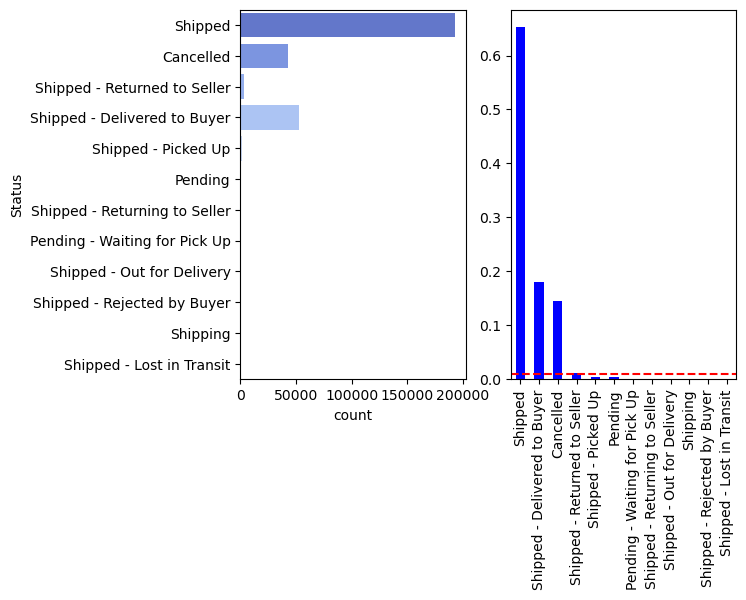

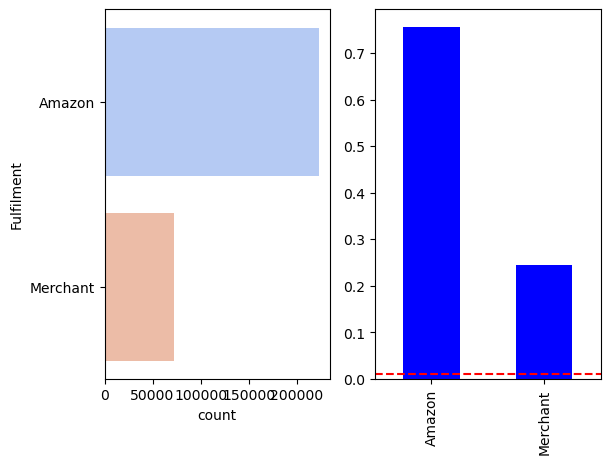

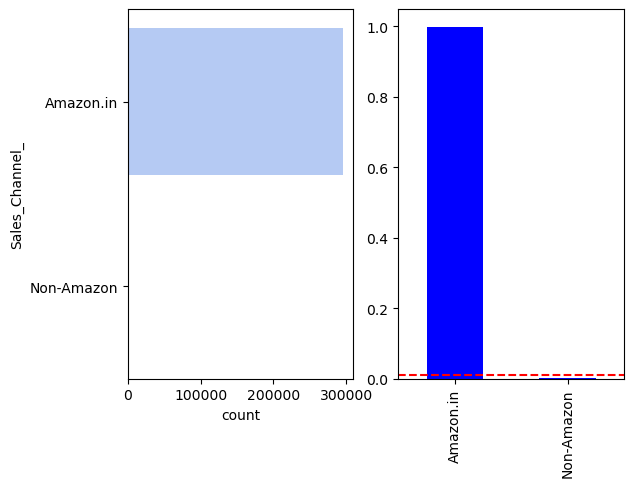

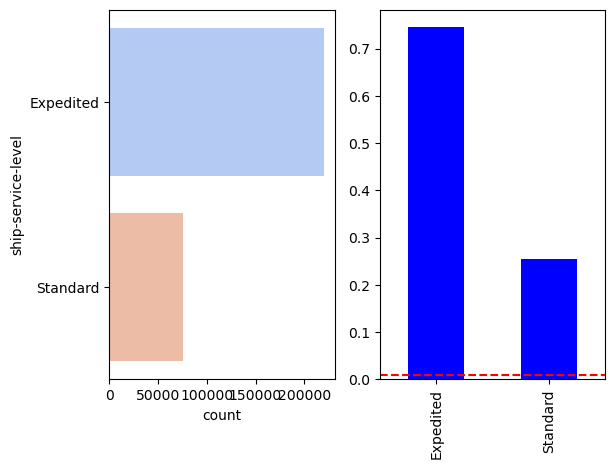

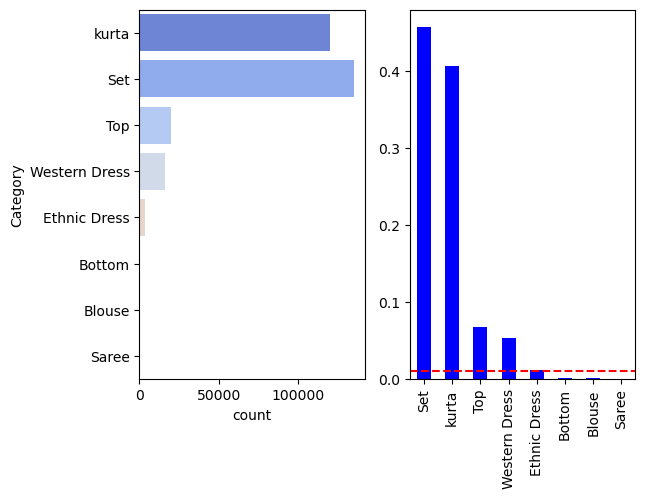

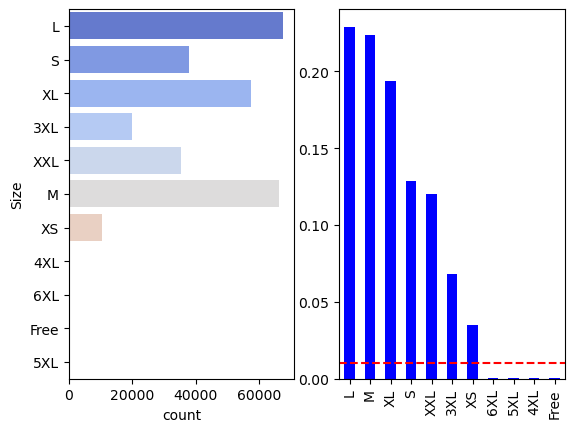

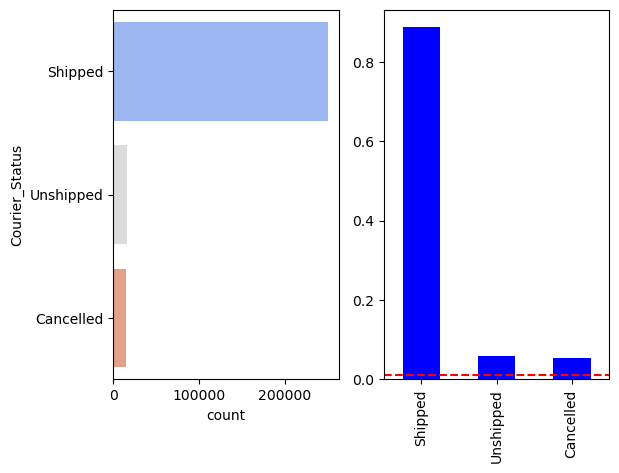

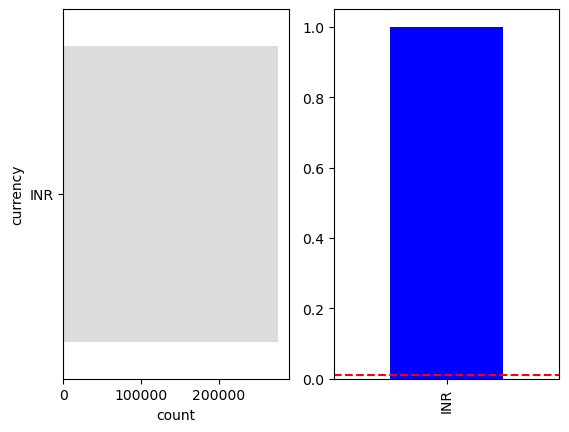

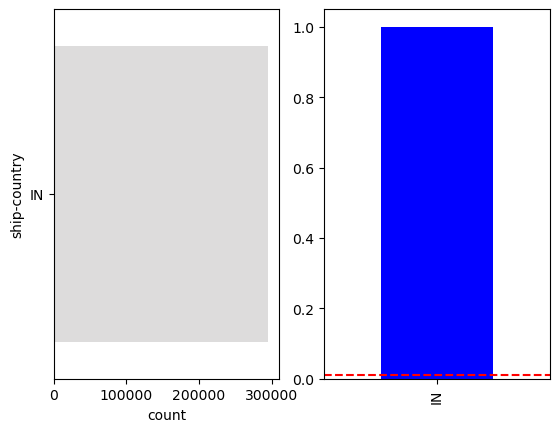

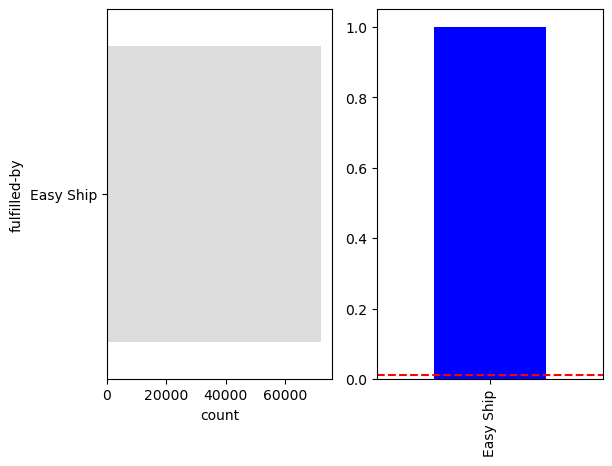

In [107]:
for column in cat_columns:
        
    if df[column].nunique()<20:
        
        fig, ax = plt.subplots(1,2)

        sns.countplot(data = df, y = column, palette = 'coolwarm', ax = ax[0])
        
        df[column].value_counts(normalize = True).plot(kind = 'bar', color = 'blue', ax = ax[1])
        
        ax[1].axhline(0.01, color = 'red', linestyle = '--')

### Univariate analysis and distribution of numerical columns

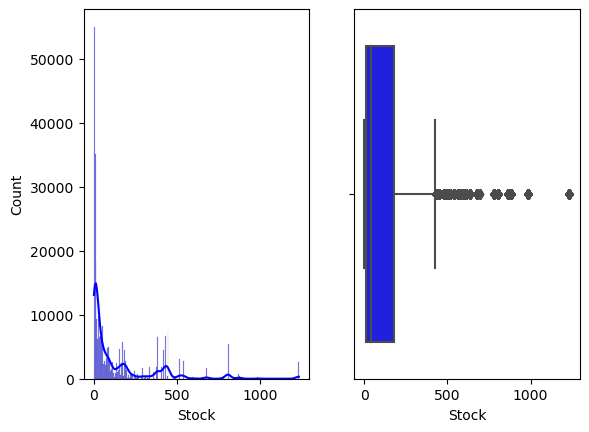

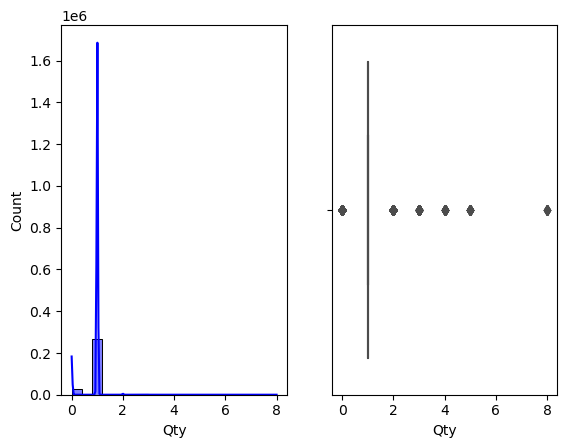

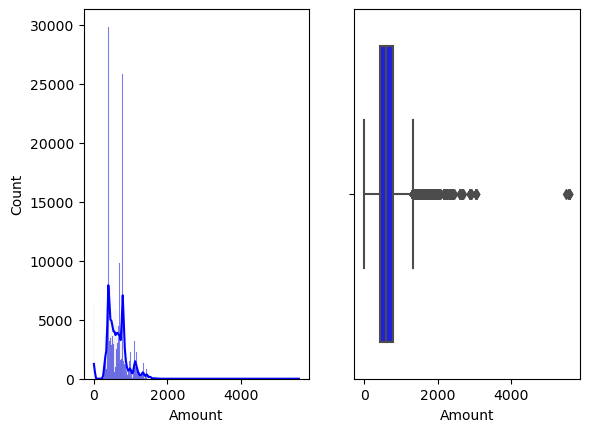

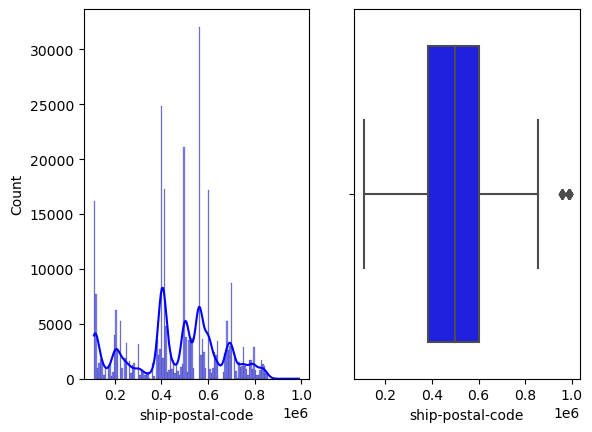

In [109]:
for column in num_columns:
    
    fig,ax = plt.subplots(1,2)
    
    sns.histplot(data = df, x = column, kde = True, color = 'blue', ax = ax[0])
    
    sns.boxplot(data = df, x = column, color = 'blue', ax = ax[1])

### Bivariate analysis 

In [121]:
# values over time
for column in date_columns:
    
    df[column] = pd.to_datetime(df[column])

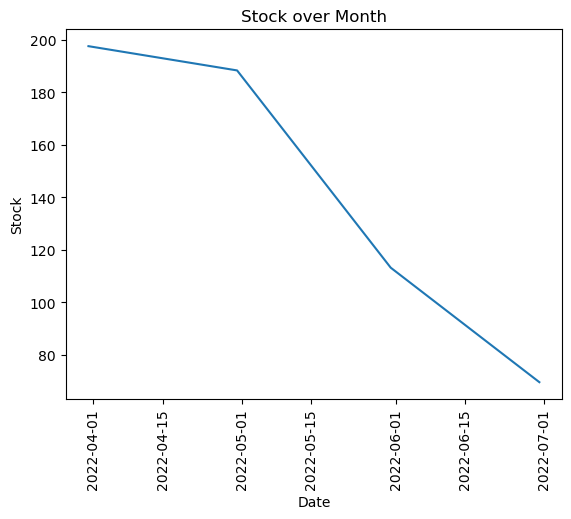

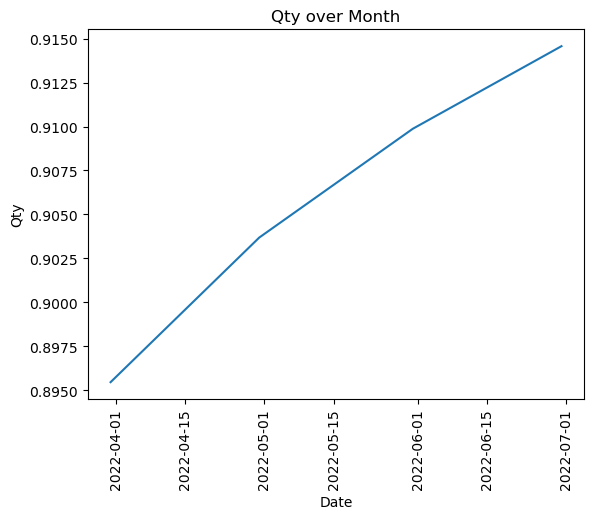

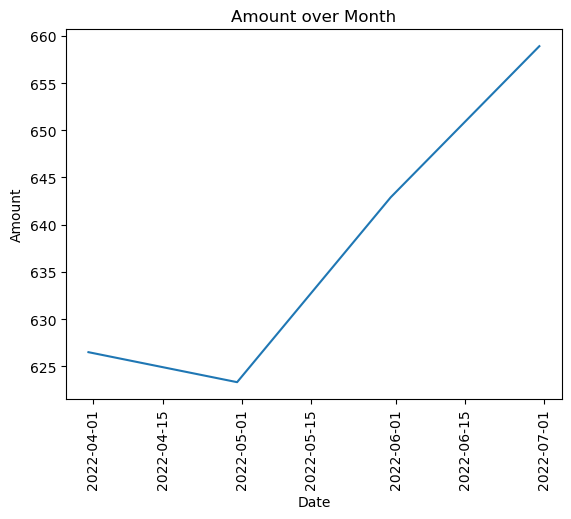

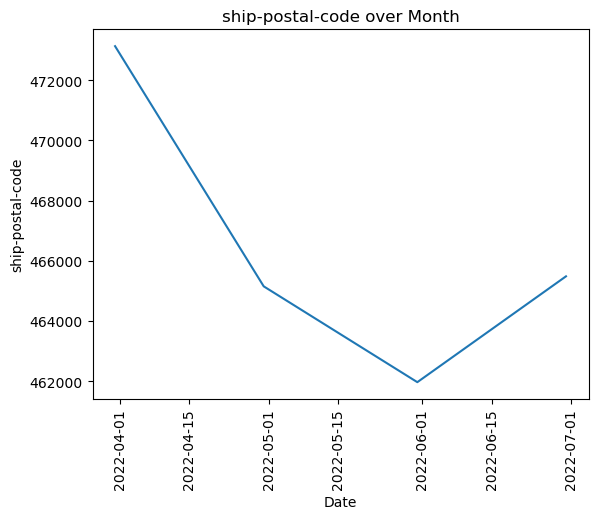

In [120]:
for date_col in date_columns:
    
    for num_col in num_columns:
        
        plt.figure()
        
        # resample to monthly average
        
        temp = df.set_index('Date').resample('M').mean()
                
        sns.lineplot(data = temp, x = date_col, y = num_col)
        
        plt.title(f'{num_col} over Month')
        
        plt.xticks(rotation = 90)

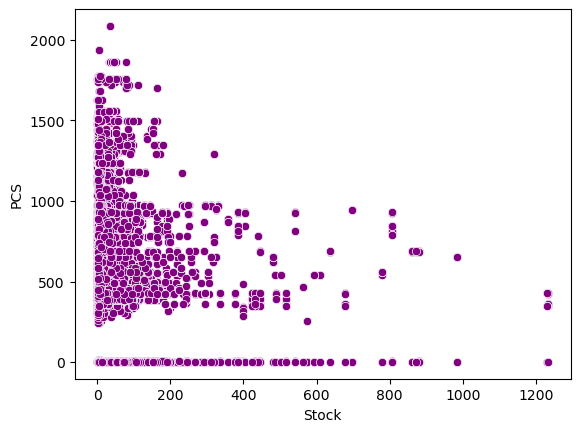

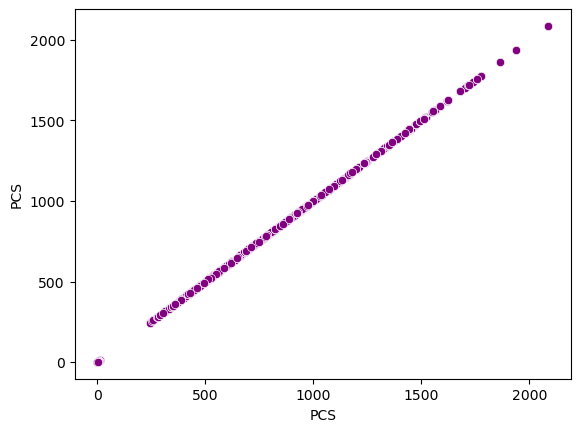

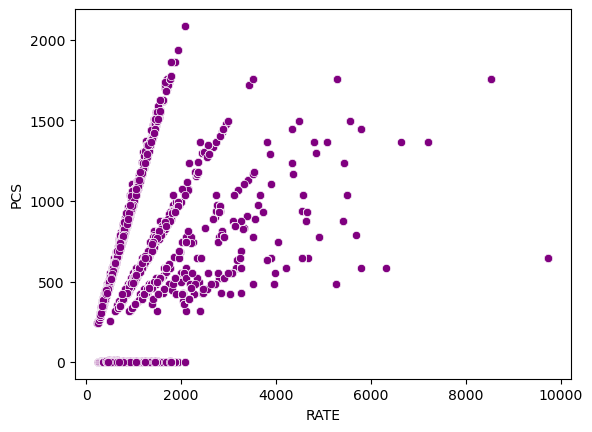

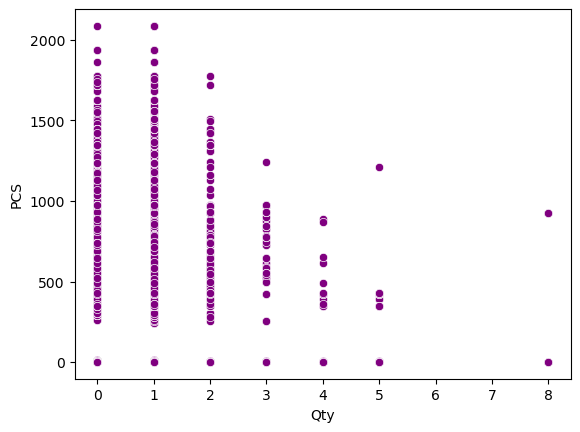

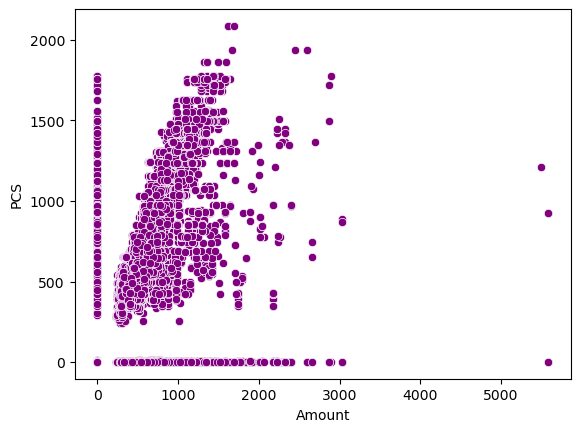

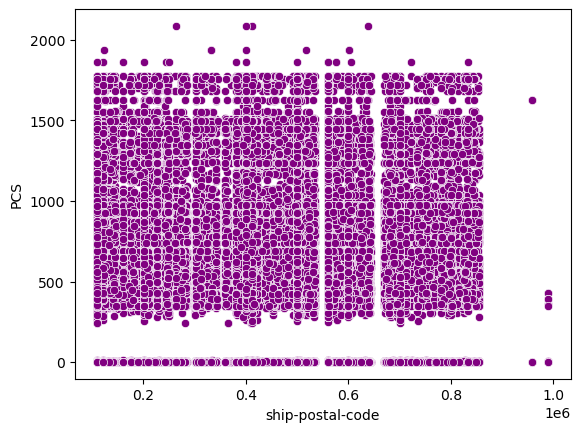

In [133]:
# relationship  with target - numerical

for num_col in num_columns:
        
    plt.figure()
    
    sns.scatterplot(data = df, x = num_col, y = target, color = 'purple')

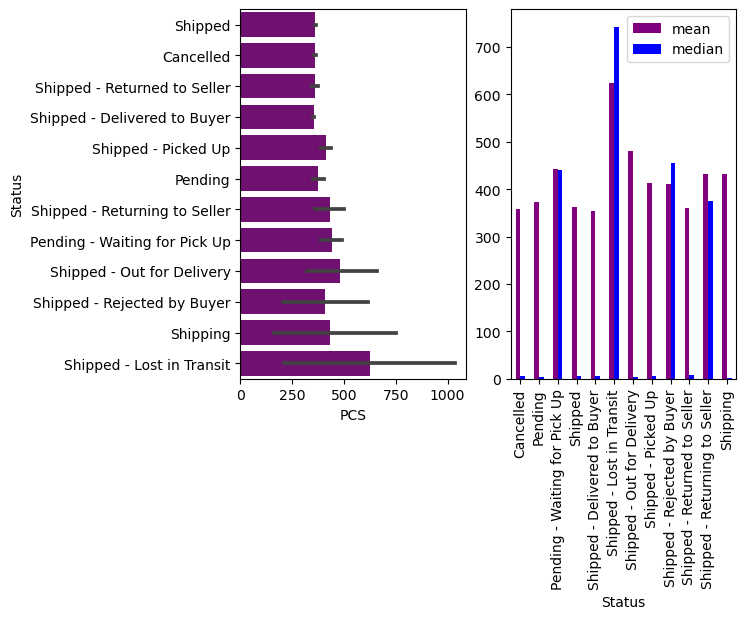

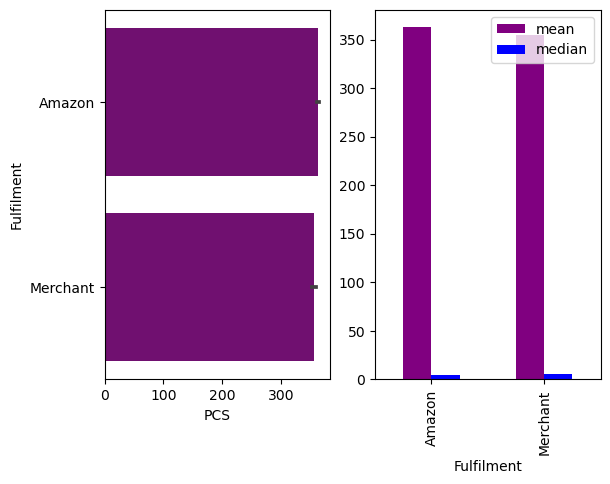

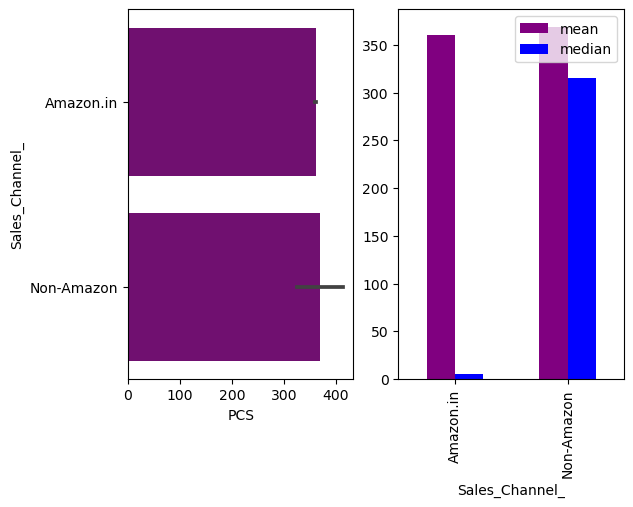

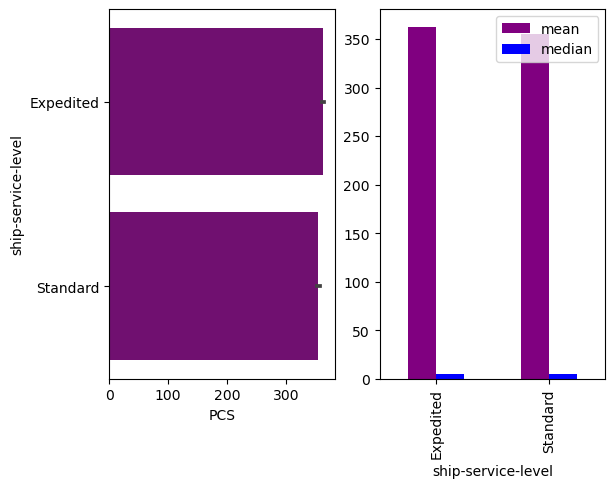

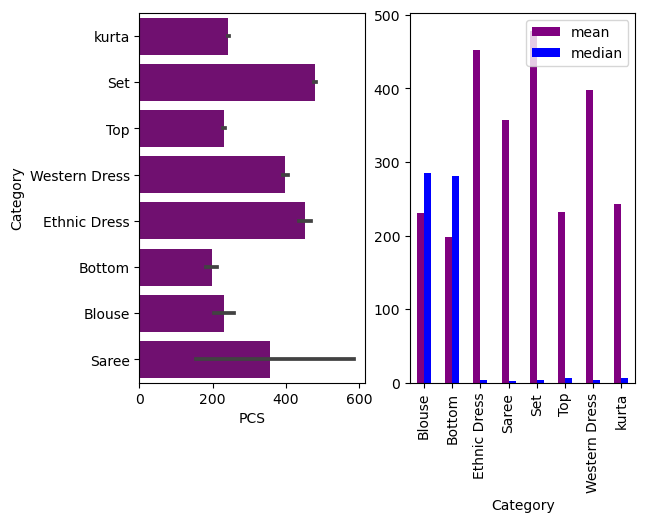

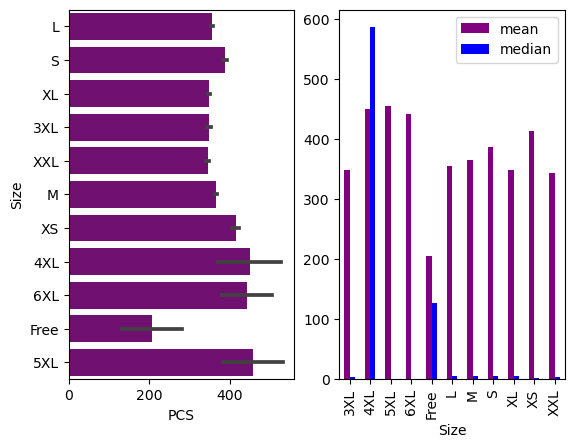

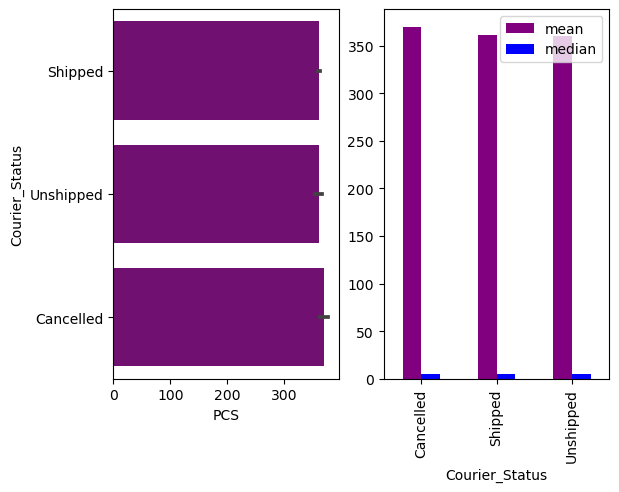

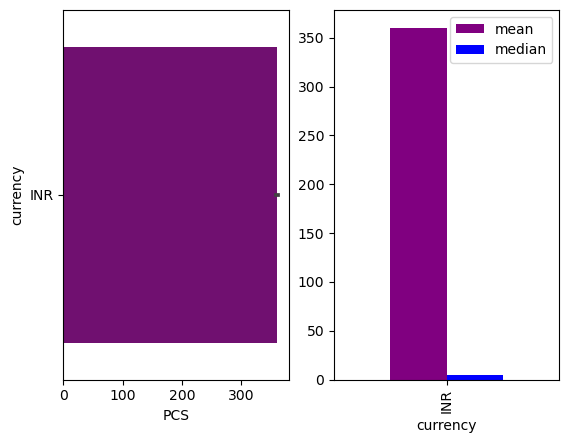

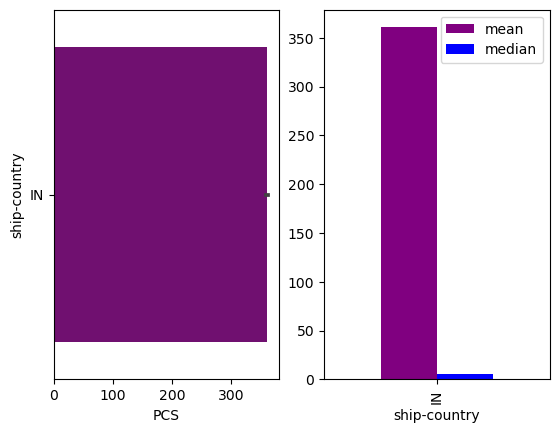

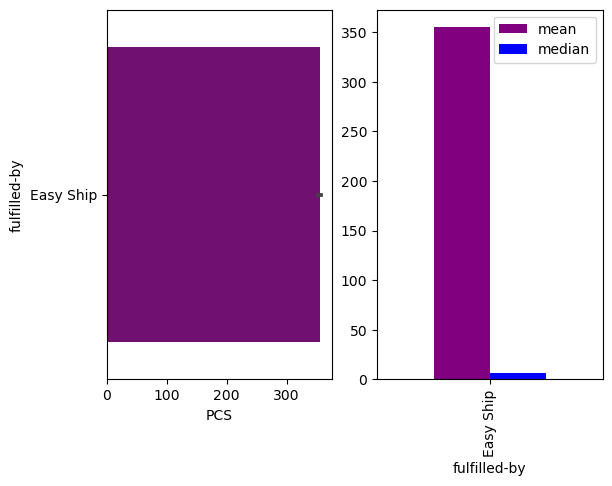

In [142]:
# relationship  with target - categorical

for column in cat_columns:
    
    if df[column].nunique()<20:
        
        fig, ax = plt.subplots(1,2)
        
        sns.barplot(data = df, y = column, x = target, color = 'purple', ax = ax[0])
        
        plt.xticks(rotation = 90)
        
        df.groupby(column)[target].agg(['mean', 'median']).plot(kind = 'bar', color = ['purple', 'blue'], ax = ax[1])
        
        plt.xticks(rotation = 90)

### Linearity

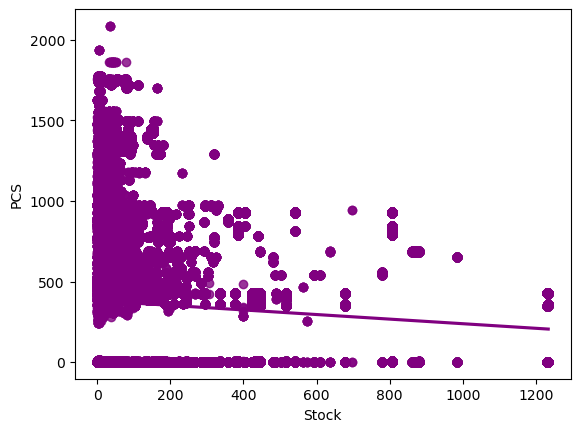

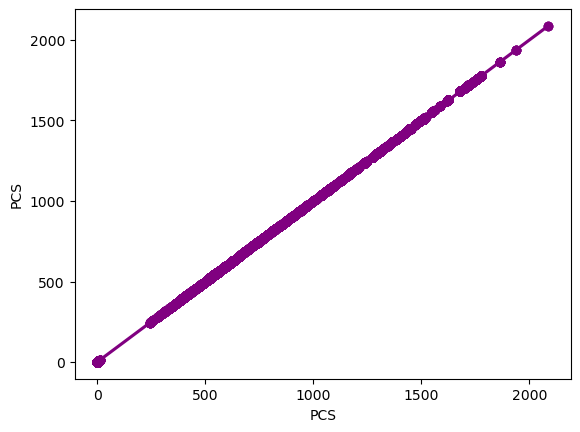

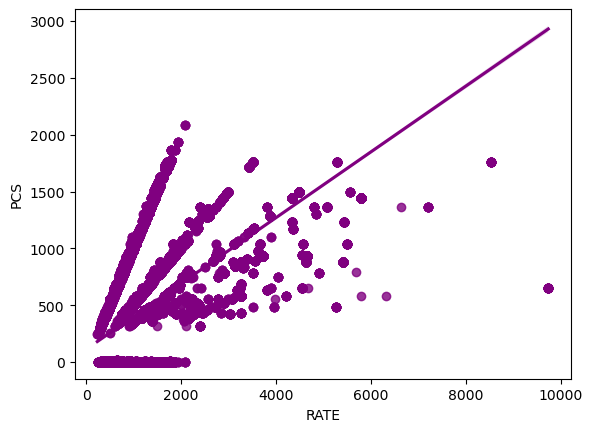

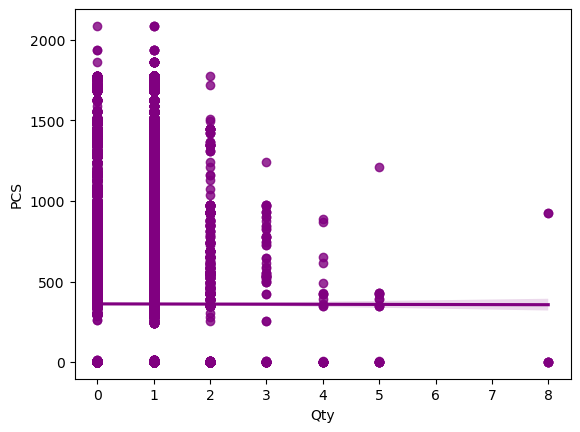

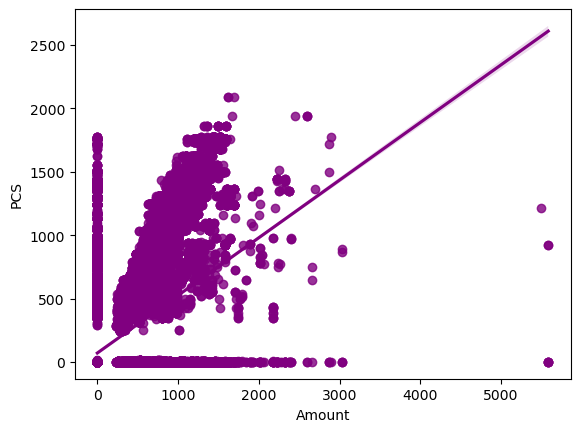

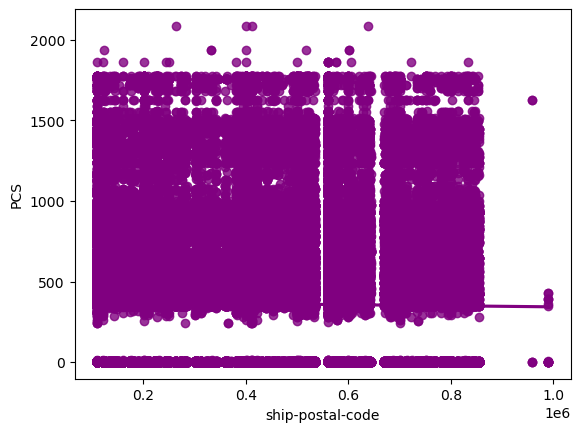

In [144]:
for num_col in num_columns:
        
    plt.figure()
    
    sns.regplot(data = df, x = num_col, y = target, color = 'purple')

### Stats

In [147]:
means = []
medians = []
skew_type = []
names = []

for column in num_columns:
    
    names.append(column)
    
    mean_ = df[column].mean()
    
    means.append(mean_)
    
    median_ = df[column].median()
    
    medians.append(median_)
    
    if mean_ == median_:
        
        skew_type.append('Normal')
        
    elif mean_ > median_:
        
        skew_type.append('Right')
        
    else:
        skew_type.append('Left')
        
        
        
pd.DataFrame({
    'Columns': names,
    'Mean': means,
    'Median': medians,
    'Skew': skew_type,    
})       

,Columns,Mean,Median,Skew
0,Stock,139.650007,41.0,Right
1,PCS,360.756290,5.0,Right
2,RATE,855.498330,688.0,Right
3,Qty,0.907926,1.0,Left
4,Amount,637.054856,599.0,Right
5,ship-postal-code,464285.906057,500034.0,Left


## Correlation

In [151]:
def correlation(data = df, method = 'pearson'):
    
    corr = df.corr(method = method)
    
    mask = np.triu(corr)
    
    sns.heatmap(corr, annot = True, mask = mask);plt.show()
    

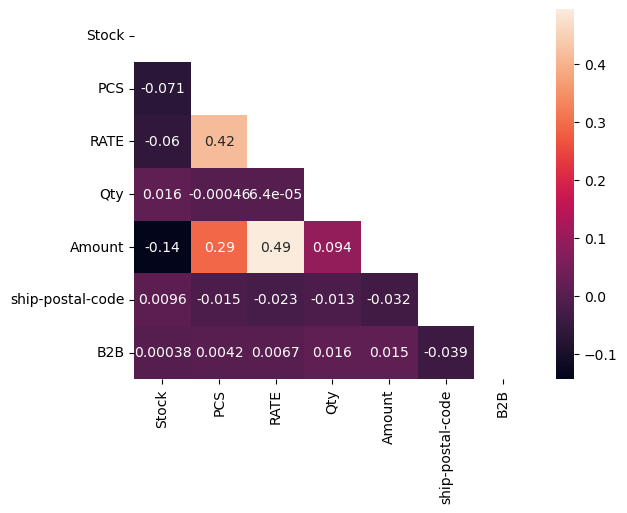

In [152]:
correlation()

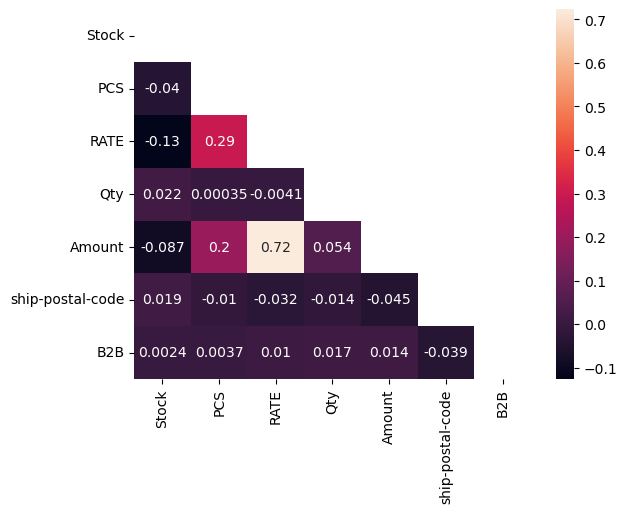

In [154]:
correlation(method = 'spearman')

### Multicollinearity

In [156]:
cols = df[num_columns].fillna(0)

vif = pd.DataFrame()

vif['VIF'] = [variance_inflation_factor(cols.values, i) for i in range(len(cols.columns))]
vif['Features'] = df[num_columns].columns

vif

,VIF,Features
0,1.421739,Stock
1,2.082404,PCS
2,3.960477,RATE
3,8.397683,Qty
4,7.584393,Amount
5,4.550164,ship-postal-code


## Normality

In [157]:
# ho: the data is normal

{column: scipy.stats.shapiro(df[column])[1] < 0.05 for column in num_columns}

{'Stock': True,
 'PCS': True,
 'RATE': True,
 'Qty': True,
 'Amount': False,
 'ship-postal-code': False}

In [158]:
num_outliers = []

for column in num_columns:
    
        Q3 = df[column].quantile(0.75)
        Q1 = df[column].quantile(0.25)
        
        IQR = Q3 - Q1
        
        upper_limit = Q3 + (1.5*IQR)
        lower_limit = Q1 - (1.5*IQR)
        
        outliers = df.loc[np.where(df[column] > upper_limit, True, np.where(df[column]<lower_limit, True, False))]
        
        num_outliers.append(len(outliers))
        
pd.DataFrame({
    'columns':num_columns,
    'Outliers':num_outliers
})

,columns,Outliers
0,Stock,33350
1,PCS,1955
2,RATE,19465
3,Qty,29204
4,Amount,7461
5,ship-postal-code,22


### Data Cleaning

In [610]:
# drop columns

def drop_columns(dataframe):
    
    """ Drops columns that have no association with target e.g OrderId, or columns with low cardinality(unique value of 1),
    Or columns that may lead to data leakage, or columns with high multicollinearity
    
    Returns: dataframe
    """
    
    for column in dataframe:
        
        dataframe.drop(column, axis = 1, inplace = True)
        
    return dataframe

func_drop_columns = FunctionTransformer(drop_columns)
cols_drop_columns = ['Order_ID', 'SKU', 'CUSTOMER', 'ship_country', 'fulfilled_by', 'RATE', 'ship_city', 'currency', 'ASIN']

In [611]:
# reduce high cardinality

def reduce_cardinality(dataframe):
    
    """ Performs a frequency of unique values in each column, returns the most frequent values and sets 
    less frequent values to Others
    
    Returns: dataframe
    """
    
    for column in dataframe:
        
        values = df[column].value_counts(normalize = True, sort = True).to_dict()
        
        to_keep = [column for column, value in values.items() if value >= 0.03]
        
        dataframe[column] = dataframe[column].apply(lambda x: x if x in to_keep else 'Others')
        
    return dataframe

func_reduce_cardinality = FunctionTransformer(reduce_cardinality)
cols_reduce_cardinality = ['Color', 'Style', 'ship_state']

In [612]:
drop_columns_pipeline = Pipeline([
    ('drop_column', func_drop_columns),
])

cardinality_pipeline = Pipeline([
    ('reduce_cardinality',func_reduce_cardinality)
])




data_cleaner = ColumnTransformer([
    ('drop_columns', drop_columns_pipeline,cols_drop_columns ),
    ('reduce_cardinality', cardinality_pipeline, cols_reduce_cardinality)
], remainder = 'passthrough', verbose_feature_names_out = False)

In [613]:
data_cleaner.fit(full_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('drop_columns',
                                 Pipeline(steps=[('drop_column',
                                                  FunctionTransformer(func=<function drop_columns at 0x0000024BC1C83D00>))]),
                                 ['Order_ID', 'SKU', 'CUSTOMER', 'ship_country',
                                  'fulfilled_by', 'RATE', 'ship_city',
                                  'currency', 'ASIN']),
                                ('reduce_cardinality',
                                 Pipeline(steps=[('reduce_cardinality',
                                                  FunctionTransformer(func=<function reduce_cardinality at 0x0000024B1D48B0A0>))]),
                                 ['Color', 'Style', 'ship_state'])],
                  verbose_feature_names_out=False)

In [614]:
full_train = data_cleaner.transform(full_train)
reduced_train = data_cleaner.transform(reduced_train)
validation = data_cleaner.transform(validation)
test = data_cleaner.transform(test)

### Regression Analysis

In [615]:
df = reduced_train.copy()
df[:1]

,Color,Style,ship_state,Stock,PCS,GROSS_AMT,Date,Status,Fulfilment,Sales_Channel_,ship_service_level,Category,Size,Courier_Status,Qty,Amount,ship_postal_code,B2B
462,Black,Others,WEST BENGAL,9.0,350,4,04-23-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Blouse,L,Shipped,1,280.0,700108.0,False


In [616]:
cat_columns = [column for column in df.columns if df[column].dtype == object or df[column].dtype == bool and column!= 'Date']

target = 'PCS'

num_columns = [column for column in df.columns if column not in cat_columns and column != 'Date' and column != target]

In [354]:
x = df.drop(target, axis = 1)
y = df[target]

In [355]:
# create formula for patsy

formula = 'PCS ~ '

for column in cat_columns:
    
    if column != 'Date':
        
        formula = formula + f'C({column}) + '
    
for column in num_columns:
    
    formula = formula + f'{column} + '


In [356]:
formula = formula[:-3]

formula

'PCS ~ C(Color) + C(Style) + C(ship_state) + C(Status) + C(Fulfilment) + C(Sales_Channel_) + C(ship_service_level) + C(Category) + C(Size) + C(Courier_Status) + C(B2B) + Stock + GROSS_AMT + Qty + Amount + ship_postal_code'

In [357]:
ytrain_patsy, xtrain_patsy = dmatrices(formula, data = df.drop('Date', axis = 1).fillna(0), return_type = 'dataframe')

In [358]:
model = sm.OLS(ytrain_patsy, xtrain_patsy).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PCS   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     5537.
Date:                Thu, 28 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:01:11   Log-Likelihood:            -2.0960e+06
No. Observations:              295577   AIC:                         4.192e+06
Df Residuals:                  295514   BIC:                         4.193e+06
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                    591.4876     27.251     21.705      0.000     538.076     644.899
C(Color)[T.Blue]                             -19.5792      2.617     -7.481      0.000     -24.709     -14.450
C(Color)[T.Green]                             13.3629      3.033      4.406      0.000       7.419      19.307
C(Color)[T.Maroon]                           -25.7476      3.503     -7.351      0.000     -32.613     -18.882
C(Color)[T.Mustard]                            5.4820      3.027      1.811      0.070      -0.452      11.416
C(Color)[T.OFF WHITE]                        190.7534      5.638     33.835      0.000     179.704     201.803
C(Color)[T.Others]                            28.8195      2.247     12.827      0.000      24.416      33.223
C(Color)[T.Pink]                              -2.0371      3.021     -0.674      0.500      -7.958       3.884
C(Color)[T.Teal]                             -51.9834      3.028    -17.167      0.000     -57.918     -46.049
C(Style)[T.JNE3405]                         -475.7587      5.429    -87.635      0.000    -486.399    -465.118
C(Style)[T.Others]                          -407.1802      3.720   -109.459      0.000    -414.471    -399.889
C(Style)[T.SET268]                          -543.0436      6.894    -78.774      0.000    -556.555    -529.532
C(ship_state)[T.DELHI]                         3.6382      4.122      0.883      0.377      -4.440      11.717
C(ship_state)[T.Gujarat]                       7.5126      4.070      1.846      0.065      -0.465      15.490
C(ship_state)[T.HARYANA]                       0.5526      4.418      0.125      0.900      -8.106       9.211
C(ship_state)[T.KARNATAKA]                   -11.0262      3.055     -3.609      0.000     -17.014      -5.039
C(ship_state)[T.KERALA]                      -10.0205      3.745     -2.676      0.007     -17.360      -2.681
C(ship_state)[T.MAHARASHTRA]                  -4.2285      3.038     -1.392      0.164     -10.184       1.727
C(ship_state)[T.Others]                        0.5254      2.986      0.176      0.860      -5.327       6.378
C(ship_state)[T.TAMIL NADU]                  -12.2208      3.255     -3.754      0.000     -18.601      -5.841
C(ship_state)[T.TELANGANA]                    -3.3974      3.266     -1.040      0.298      -9.798       3.003
C(ship_state)[T.UTTAR PRADESH]                 1.2421      3.590      0.346      0.729      -5.794       8.278
C(ship_state)[T.WEST BENGAL]                  -7.8385      3.744     -2.094      0.036     -15.176      -0.501
C(Status)[T.Pending]                           1.0826     11.772      0.092      0.927     -21.990      24.155
C(Status)[T.Pending - Waiting for Pick Up]    40.2514     23.801      1.691      0.091

### Identifying heteroskedasticity


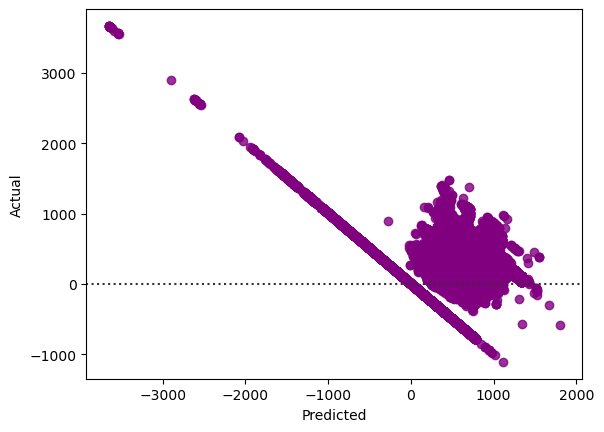

In [359]:
ypred = model.predict(xtrain_patsy)

residuals = ytrain_patsy['PCS'] - ypred

sns.residplot(x = model.predict(xtrain_patsy), y = residuals, color = 'purple')
plt.xlabel('Predicted'); plt.ylabel('Actual');

1. Is there a relationship between the features and target variable?
 
 Using the f-statistic with null hypothesis: All betas are 0.
 The pvalue is less than 0.05 and f-statistic id greater than 1. There is a relationhsip.

 2. How strong is the relationship?

Adjusted R2 shows the features explain 53.75 of the variability in the target

3. Which variables are related to the target?

 Using the t-statistic and pvalues score, we notice some values are related and some are not.

In [361]:
model_pvalues = dict(zip(xtrain_patsy.columns, model.pvalues))

[column for column, pvalue in model_pvalues.items() if pvalue < 0.05]

['Intercept',
 'C(Color)[T.Blue]',
 'C(Color)[T.Green]',
 'C(Color)[T.Maroon]',
 'C(Color)[T.OFF WHITE]',
 'C(Color)[T.Others]',
 'C(Color)[T.Teal]',
 'C(Style)[T.JNE3405]',
 'C(Style)[T.Others]',
 'C(Style)[T.SET268]',
 'C(ship_state)[T.KARNATAKA]',
 'C(ship_state)[T.KERALA]',
 'C(ship_state)[T.TAMIL NADU]',
 'C(ship_state)[T.WEST BENGAL]',
 'C(Status)[T.Shipped - Lost in Transit]',
 'C(Fulfilment)[T.Merchant]',
 'C(Sales_Channel_)[T.Non-Amazon]',
 'C(ship_service_level)[T.Standard]',
 'C(Category)[T.Bottom]',
 'C(Category)[T.Ethnic Dress]',
 'C(Category)[T.Set]',
 'C(Category)[T.Western Dress]',
 'C(Category)[T.kurta]',
 'C(Size)[T.4XL]',
 'C(Size)[T.5XL]',
 'C(Size)[T.6XL]',
 'C(Size)[T.L]',
 'C(Size)[T.M]',
 'C(Size)[T.S]',
 'C(Size)[T.XL]',
 'C(Size)[T.XS]',
 'C(Size)[T.XXL]',
 'C(Courier_Status)[T.Cancelled]',
 'C(Courier_Status)[T.Shipped]',
 'C(Courier_Status)[T.Unshipped]',
 'GROSS_AMT',
 'Qty',
 'Amount']

## Split Data

In [617]:
xtrain_red = reduced_train.drop(target, axis = 1)
ytrain_red = reduced_train[target]

xtrain = full_train.drop(target, axis = 1)
ytrain = full_train[target]

xtest= test.drop(target, axis = 1)
ytest = test[target]

xvalidation = validation.drop(target, axis = 1)
yvalidation = validation[target]

## Choose Performance metric

Will prioritize MAE since we have outliers

<Axes: >

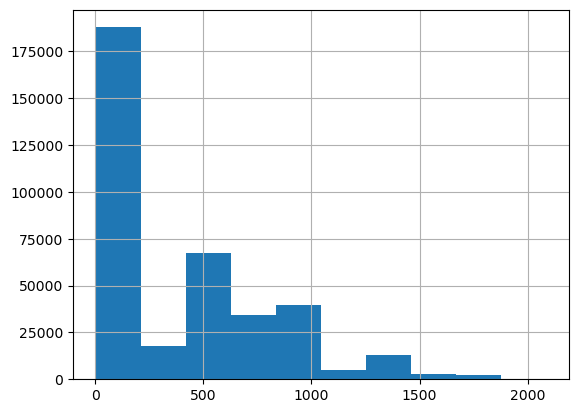

In [363]:
ytrain.hist()

## Baseline model

In [364]:
x_dummy = xtrain_red.drop(['Date'], axis = 1)
y_dummy = ytrain_red.copy()

In [310]:
dummy = DummyRegressor(strategy='median')

In [311]:
x_dummy = pd.get_dummies(x_dummy.fillna(0))
dummy.fit(x_dummy, y_dummy)

DummyRegressor(strategy='median')

In [312]:
dummy_pred = dummy.predict(x_dummy)

In [524]:
baseline = pd.DataFrame({
    'Model':['Baseline'],
    'R2':r2_score(y_dummy, dummy_pred),
    'RMSE':np.sqrt(mean_squared_error(y_dummy, dummy_pred)),
    'MAE':mean_absolute_error(y_dummy, dummy_pred)    
}, index = [0])

baseline

,Model,R2,RMSE,MAE
0,Baseline,-0.692897,556.075274,359.495607


## Model Building

In [454]:
models = []

models.append( ('Enet', ElasticNet()) )
models.append( ('Tree', DecisionTreeRegressor()) )
models.append( ('Xgboost', xgb.XGBRegressor()) )
models.append( ('Ext_trees', ExtraTreesRegressor()) )
models.append( ('KNN', KNeighborsRegressor()) )

In [499]:
def evaluate_model(xtrain, ytrain, experiment_number, models = models, is_target_log = False):
    
    names = []
    r2_scores = []
    mae_scores = []
    rmse_scores = []
    
    for name, model in models:
        
        names.append(name)
        
        r2 = cross_val_score(model, xtrain, ytrain, cv = 5, scoring = 'r2').mean()
        r2_scores.append(r2)
        
        mae = -cross_val_score(model, xtrain, ytrain, cv = 5, scoring = 'neg_mean_absolute_error').mean()
        
        rmse = -cross_val_score(model, xtrain, ytrain, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
        
        ypred = cross_val_predict(model, xtrain, ytrain, cv = 5)
        
        if is_target_log:
            
            ypred = np.expm1(ypred)
            ytrain = np.expm1(ytrain)
            mae_scores.append(np.exp(mae))
            rmse_scores.append(np.exp(rmse))
            
        else:
            
            mae_scores.append(mae)
            rmse_scores.append(rmse)
            

        sns.kdeplot(data = ytrain, label = 'Actual', shade = True, color = 'blue')
        sns.kdeplot(data = ypred, label = 'Predicted', shade = True, color = 'red')
        plt.legend();plt.title(name);plt.show()
        
    return pd.DataFrame({
        'Model':[f'{name}_{experiment_number}' for name in names],
        'R2':r2_scores,
        'MAE':mae_scores,
        'RMSE':rmse_scores,    
    })

## Model Selection

In [618]:
target = 'PCS'

num_columns = [column for column in full_train.select_dtypes('number').columns.tolist() if column != target]

cat_columns = [column for column in xtrain_red.columns if column not in num_columns and column!= 'Date']

date_columns = ['Date']

### Experiment 0

1. Missing values: drop
2. Encoding: One-Hot
3. Tranformation: None
4. Outliers: None
5. Scaling: None
6. Feature selecion: None
7. Target: None

In [391]:
temp_0 = pd.concat([xtrain_red, ytrain_red], axis = 1)
temp_0.shape

(295577, 18)

In [392]:
# drop columns
temp_0 = temp_0.dropna()

temp_0.shape

(266824, 18)

In [393]:
def date_transformer(dataframe):
    
    for column in dataframe:
        
        dataframe[column] = pd.to_datetime(dataframe[column])
        
        dataframe[f'{column}_year'] = dataframe[column].dt.year
        dataframe[f'{column}_month'] = dataframe[column].dt.month
        dataframe[f'{column}_day'] = dataframe[column].dt.day
        
        dataframe.drop(column, axis = 1, inplace = True)
        
    return dataframe
    
func_date_transformer = FunctionTransformer(date_transformer)

In [394]:
date_pipeline = Pipeline([
    ('date_transformer', func_date_transformer)
])

cat_pipeline = Pipeline([
    ('cat_transformer', OneHotEncoder())
])

In [398]:
pipeline_0 = ColumnTransformer([
    ('date_transformer', date_pipeline, date_columns),
    ('cat_transformer', cat_pipeline, cat_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)

In [399]:
xtrain0 = temp_0.drop([target], axis = 1)
ytrain0 = temp_0[target]

In [400]:
xtrain0 = pipeline_0.fit_transform(xtrain0)

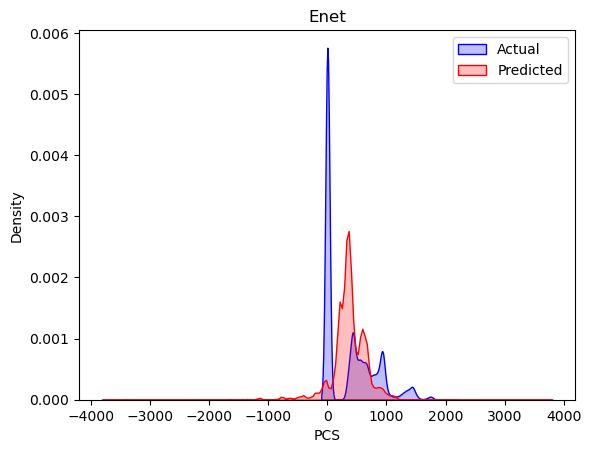

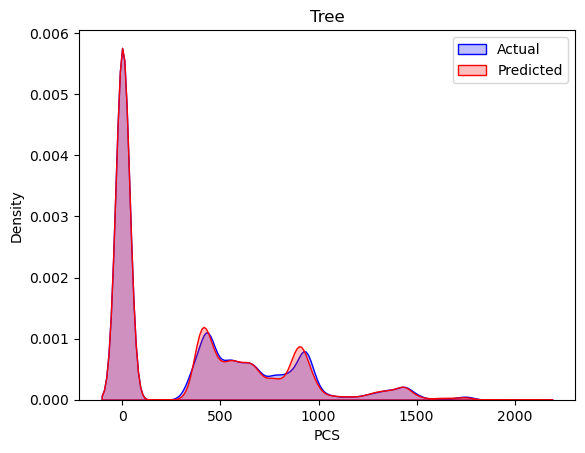

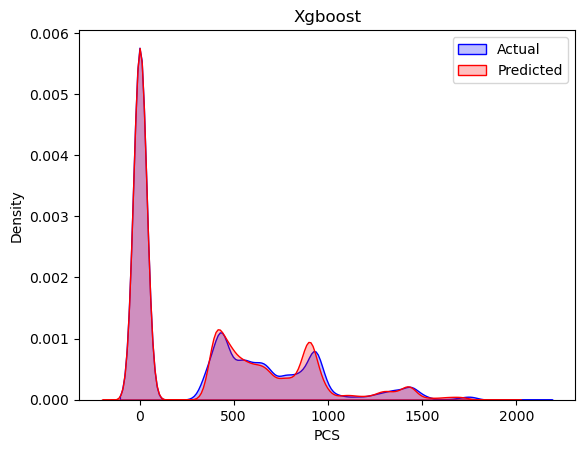

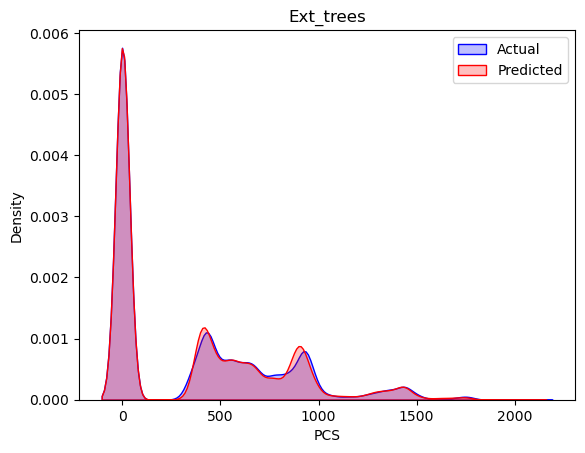

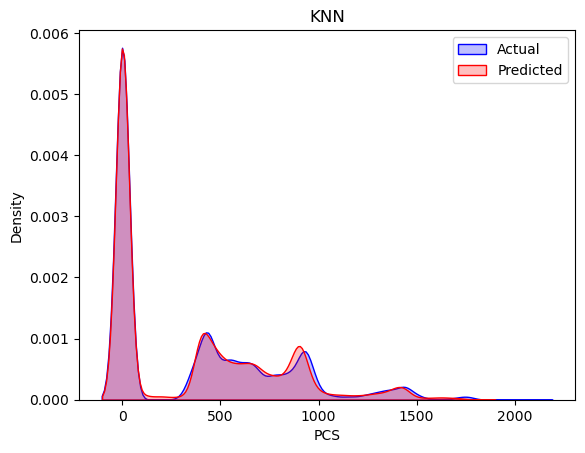

,Model,R2,MAE,RMSE
0,Enet_0,0.499860,242.751107,302.202613
1,Tree_0,0.992679,13.516817,36.584588
2,Xgboost_0,0.992829,18.161451,36.185755
3,Ext_trees_0,0.993637,13.505993,34.065439
4,KNN_0,0.952543,40.503100,93.087834


In [456]:
metrics0 = evaluate_model(xtrain0, ytrain0, 0)
metrics0

### Experiment 1

1. Missing values: simpleImputer
2. Encoding: Target
3. Tranformation: Yeo-johnson
4. Outliers: Q95
5. Scaling: Standard
6. Feature selecion: Permutation Importance
7. Target: Log

In [500]:
xtrain1, ytrain1 = xtrain_red.copy(), ytrain_red.copy()

In [501]:
def winsorize(dataframe):
    
    """Replace any values greater than the band(95th percentile) with the band"""
    
    for column in dataframe:
        
        q95 = dataframe[column].quantile(0.95)
        
        dataframe[column] = np.where(dataframe[column] > q95, q95, dataframe[column])
        
    return dataframe

func_winsorize = FunctionTransformer(winsorize)

In [502]:
# create num pipeline for numerical variables
num_pipeline = Pipeline([
    ('transformer', PowerTransformer(method = 'yeo-johnson')),
    ('scaler', StandardScaler()),  
    ('outliers', func_winsorize),
    ('imputer', SimpleImputer(strategy = 'median')),

])


# create cat pipeline for categorical variables
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
])



# create full preprocessor pipeline
pipeline_1 = ColumnTransformer([
    ('date_transformer', date_pipeline, date_columns),
    ('num_transformer', num_pipeline, num_columns),
    ('cat_transformer', cat_pipeline, cat_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)



# fit preprocessor
xtrain1 = pipeline_1.fit_transform(xtrain1)

In [ ]:
# Feature selecion: Permutation Importance

model_perm = xgb.XGBRegressor().fit(xtrain1, ytrain1)

In [465]:
r = permutation_importance(model_perm, xtrain1, ytrain1,
                          n_repeats=5,
                          random_state=0)

values = dict(zip(xtrain1.columns, r.importances_mean))
values

{'Date_year': 0.0,
 'Date_month': 1.9918857673695277e-05,
 'Date_day': 5.583139752873833e-06,
 'Stock': 0.022412422830369438,
 'GROSS_AMT': 1.8960160031831599,
 'Qty': 5.641398549429688e-05,
 'Amount': 0.004529387942180052,
 'ship_postal_code': 4.8731744660912565e-06,
 'Color_1': 0.0015104048500447886,
 'Color_2': 0.00030495295506440814,
 'Color_3': 0.0025839645071644934,
 'Color_4': 0.000186638925297955,
 'Color_5': 2.782745659701824e-05,
 'Color_6': 5.19079614506035e-05,
 'Color_7': 0.007201566560829242,
 'Color_8': 8.353961018481293e-05,
 'Color_9': 2.7596558298315088e-05,
 'Style_1': 0.0001110305369000919,
 'Style_2': 6.171479651095879e-07,
 'Style_3': 9.941753390632079e-05,
 'Style_4': 0.00024798642290766446,
 'ship_state_1': 0.0,
 'ship_state_2': 4.9548835723278727e-08,
 'ship_state_3': 3.2075420004495924e-07,
 'ship_state_4': 8.183851772480822e-07,
 'ship_state_5': 3.022888490633591e-08,
 'ship_state_6': 9.647667596146548e-07,
 'ship_state_7': 2.0129956184167242e-07,
 'ship_stat

In [532]:
values = dict(zip(xtrain1.columns, r.importances_mean))


In [534]:
selected_cols_1 = [column for column,value in values.items() if abs(value) >= 0.000005]

selected_cols_1

['Date_day',
 'Stock',
 'GROSS_AMT',
 'Qty',
 'Amount',
 'Color_1',
 'Color_3',
 'Color_4',
 'Color_5',
 'Color_6',
 'Color_7',
 'Color_8',
 'Color_9',
 'Style_1',
 'Style_3',
 'Style_4',
 'Category_1',
 'Category_2',
 'Size_10']

In [504]:
xtrain1 = xtrain1[selected_cols_1]

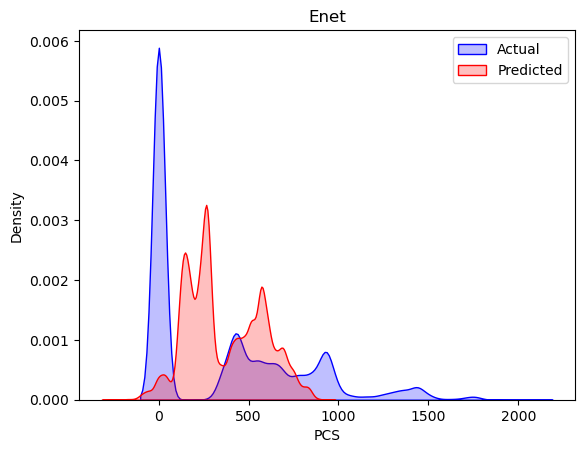

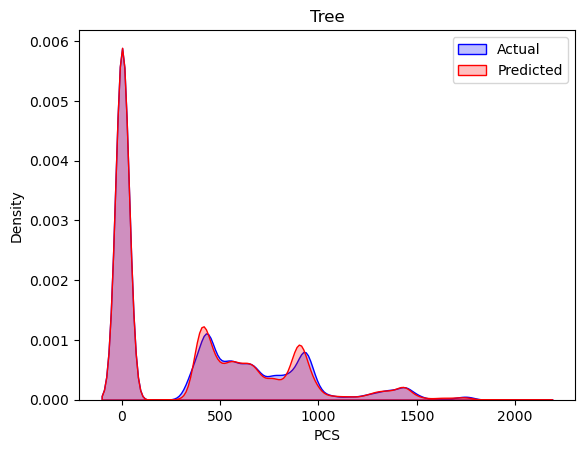

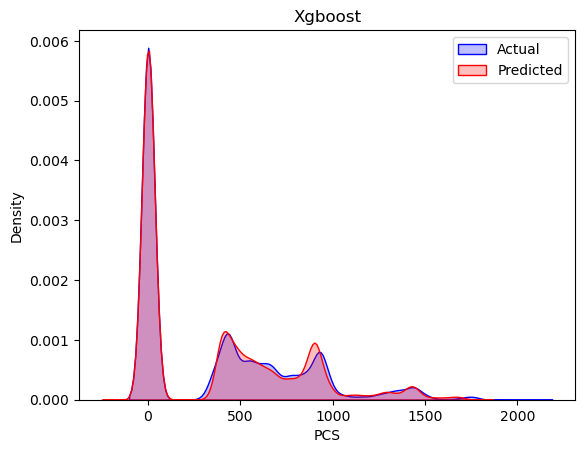

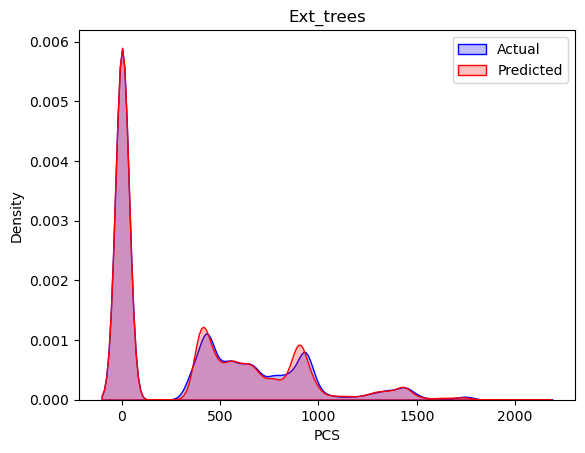

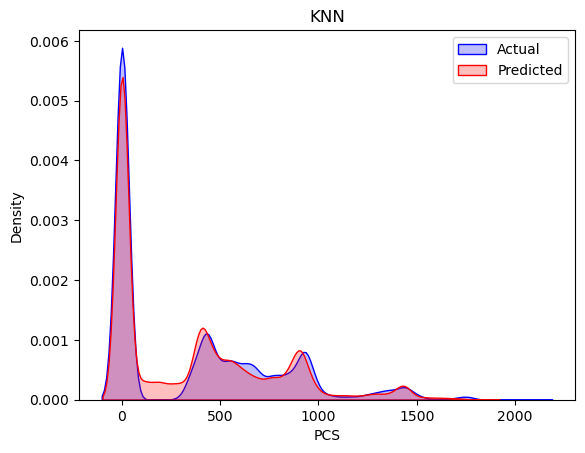

,Model,R2,MAE,RMSE
0,Enet_1,0.559706,223.491180,283.586373
1,Tree_1,0.991781,13.231089,38.768507
2,Xgboost_1,0.990133,19.860572,42.449412
3,Ext_trees_1,0.993611,12.885736,34.228653
4,KNN_1,0.926253,52.969141,116.058014


In [506]:
metrics1 = evaluate_model(xtrain1, ytrain1, 1, is_target_log = False)
metrics1

### Experiment 2

1. Missing values: Random sample Imputer
2. Encoding: Count
3. Tranformation: Poly
4. Outliers: Q95 - Q5
5. Scaling: MaxAbs
6. Feature selecion: fregression
7. Target: Log

In [507]:
xtrain2, ytrain2 = xtrain_red.copy(), ytrain_red.copy()

In [508]:
def winsorize(dataframe):
    
    """Replace any values greater than the band(95th percentile) with the band"""
    
    for column in dataframe:
        
        q95 = dataframe[column].quantile(0.95)
        
        q5 = dataframe[column].quantile(0.05)
        
        dataframe[column] = np.where(dataframe[column] > q95, q95, np.where(dataframe[column] < q5, q5, dataframe[column]))
        
    return dataframe

func_winsorize = FunctionTransformer(winsorize)

In [509]:
def random_sample_imputer(dataframe):
    
    for column in dataframe:
        
        nans = dataframe[column].isnull().sum()
        
        sample = dataframe[column].dropna().sample(nans)
        
        sample.index = dataframe.loc[dataframe[column].isnull(), column].index
        
        dataframe.loc[dataframe[column].isnull(), column] = sample
        
    return dataframe

func_random_sample_imputer = FunctionTransformer(random_sample_imputer)

In [510]:
def count_encoder(dataframe):
    
    for column in dataframe:
        
        count = dataframe[column].value_counts().to_dict()
        
        dataframe[column] = dataframe[column].map(count)
        
    return dataframe

func_count_encoder = FunctionTransformer(count_encoder)

In [511]:
# create num pipeline for numerical variables
num_pipeline = Pipeline([
    ('imputer', func_random_sample_imputer),
    ('transformer', PolynomialFeatures(degree = 2)),
    ('scaler', MaxAbsScaler()),  
    ('outliers', func_winsorize)
])


# create cat pipeline for categorical variables
cat_pipeline = Pipeline([
    ('imputer', func_random_sample_imputer),
    ('encoder', func_count_encoder),
])



# create full preprocessor pipeline
pipeline_2 = ColumnTransformer([
    ('date_transformer', date_pipeline, date_columns),
    ('num_transformer', num_pipeline, num_columns),
    ('cat_transformer', cat_pipeline, cat_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)



# fit preprocessor
xtrain2 = pipeline_2.fit_transform(xtrain2)

In [512]:
# Feature selecion: Fregression

f_statistic, pvalues = f_regression(xtrain2, ytrain2)

values = dict(zip(xtrain2.columns, pvalues))

**Null hypothesis: The null hypothesis for the F test claims that there is no predictive relationship between the X variables and Y in the population**

In [513]:
selected_cols = [column for column,value in values.items() if value <= 0.05]

xtrain2 = xtrain2[selected_cols]
xtrain2.shape

(295577, 28)

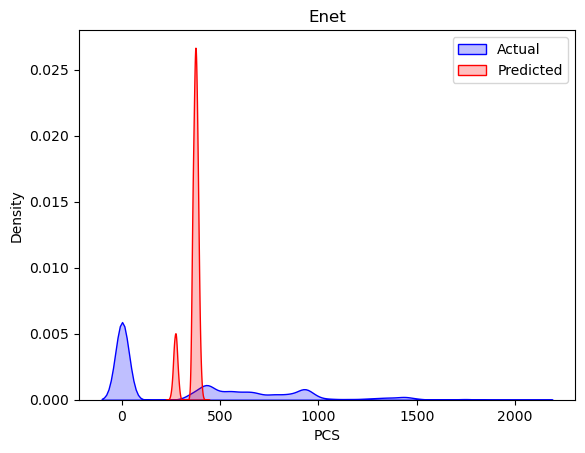

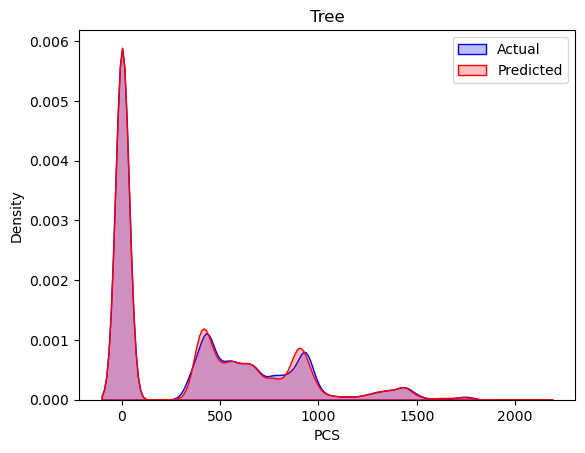

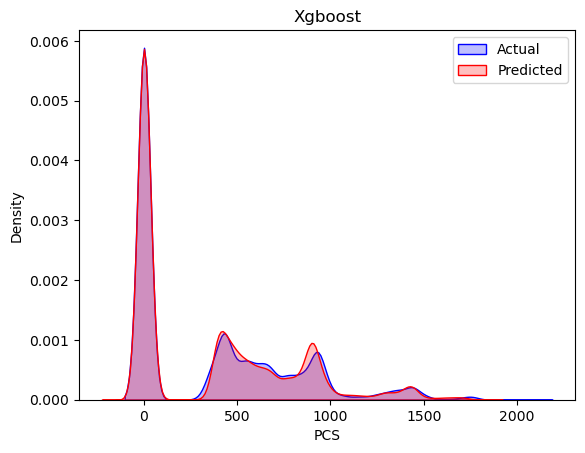

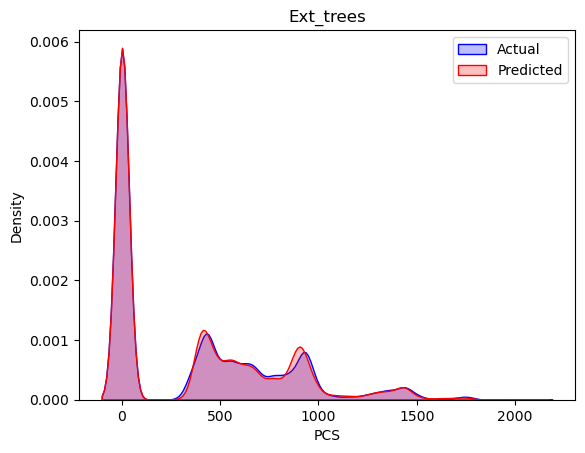

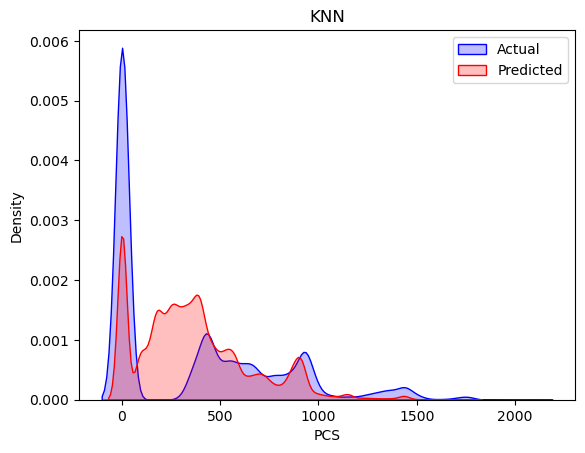

,Model,R2,MAE,RMSE
0,Enet_2,0.017781,363.606195,423.561421
1,Tree_2,0.984635,16.494904,52.763930
2,Xgboost_2,0.988080,21.596052,46.656337
3,Ext_trees_2,0.989565,16.051458,43.691001
4,KNN_2,0.441251,227.155432,319.459638


In [514]:
metrics2 = evaluate_model(xtrain2, ytrain2, 2, is_target_log = False)
metrics2

### Experiment 3

1. Missing values: SimpleImputer
2. Encoding: One-hot
3. Tranformation: Log
4. Outliers: Q95 - Q5
5. Scaling: StandardScaler
6. Feature selecion: Elasticnet coef
7. Target: None

In [515]:
xtrain3, ytrain3 = xtrain_red.copy(), ytrain_red.copy()

In [516]:
# create num pipeline for numerical variables
num_pipeline = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),  
    ('outliers', func_winsorize)
])


# create cat pipeline for categorical variables
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
])



# create full preprocessor pipeline
pipeline_3 = ColumnTransformer([
    ('date_transformer', date_pipeline, date_columns),
    ('num_transformer', num_pipeline, num_columns),
    ('cat_transformer', cat_pipeline, cat_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)



# fit preprocessor
xtrain3 = pipeline_3.fit_transform(xtrain3)

In [517]:
# Feature selection: Elasticnet coef

enet = ElasticNet()

enet.fit(xtrain3, ytrain3)

values = dict(zip(xtrain3.columns, enet.coef_))

In [518]:
selected_cols = [column for column,value in values.items() if value > 0]
len(selected_cols)

21

In [519]:
xtrain3 = xtrain3[selected_cols]
xtrain3.shape

(295577, 21)

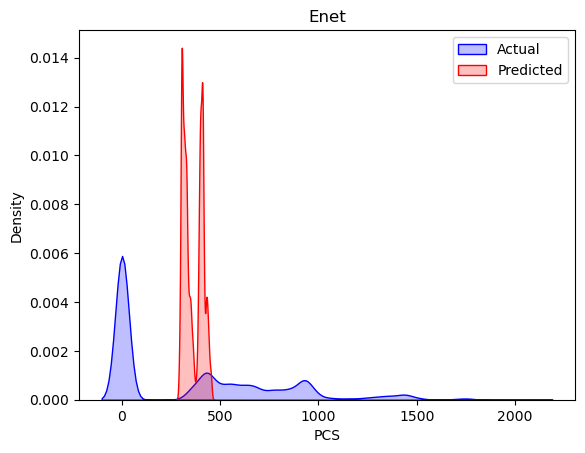

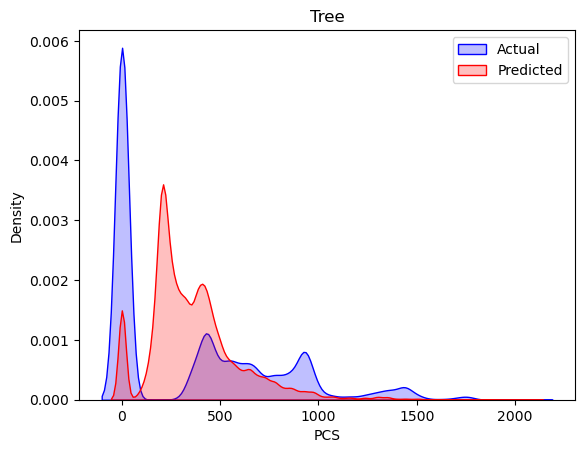

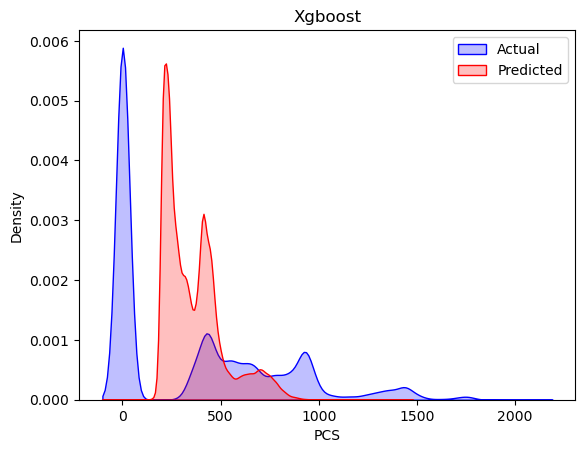

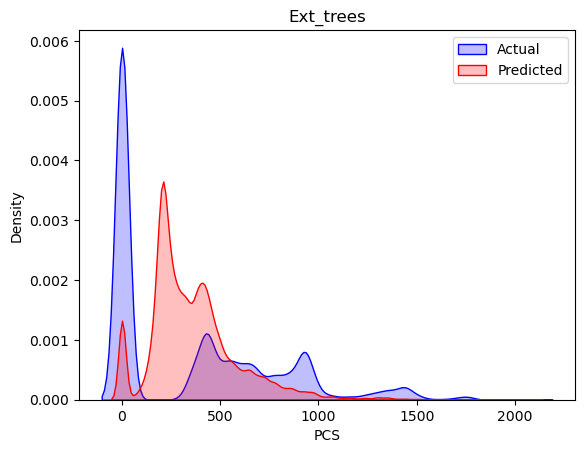

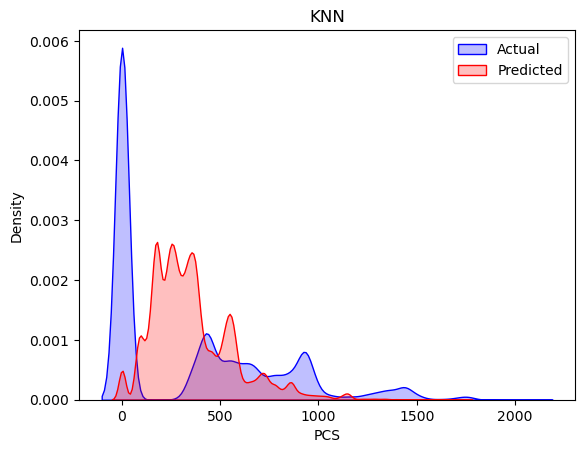

,Model,R2,MAE,RMSE
0,Enet_3,0.053778,365.529677,415.727098
1,Tree_3,-0.254133,409.144475,478.644994
2,Xgboost_3,0.094831,369.318532,406.604845
3,Ext_trees_3,-0.241214,408.811825,476.165089
4,KNN_3,-0.120745,387.816317,452.438364


In [520]:
metrics3 = evaluate_model(xtrain3, ytrain3, 3)
metrics3

## Results

In [529]:
metrics = pd.concat([metrics0,metrics1,metrics2,metrics3], axis = 0
                   )

# # return models that performed than the baseline
# metrics = metrics[
#     (metrics['R2']>baseline['R2']) &
#     (metrics['MAE']>baseline['MAE']) &
#     (metrics['RMSE']>baseline['RMSE']) 
# ]

metrics

,Model,R2,MAE,RMSE
0,Enet_0,0.499860,242.751107,302.202613
1,Tree_0,0.992679,13.516817,36.584588
2,Xgboost_0,0.992829,18.161451,36.185755
3,Ext_trees_0,0.993637,13.505993,34.065439
4,KNN_0,0.952543,40.503100,93.087834
0,Enet_1,0.559706,223.491180,283.586373
1,Tree_1,0.991781,13.231089,38.768507
2,Xgboost_1,0.990133,19.860572,42.449412
3,Ext_trees_1,0.993611,12.885736,34.228653
4,KNN_1,0.926253,52.969141,116.058014


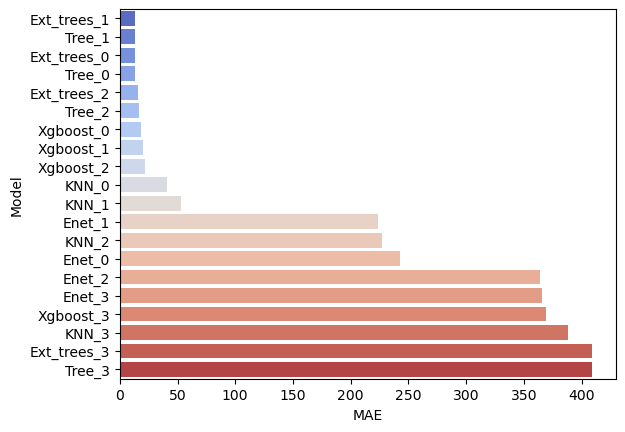

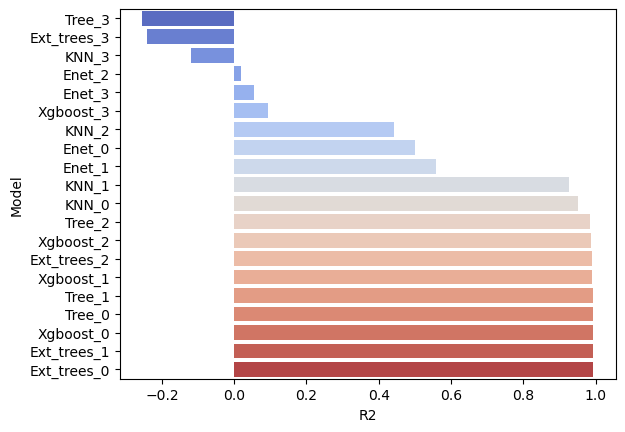

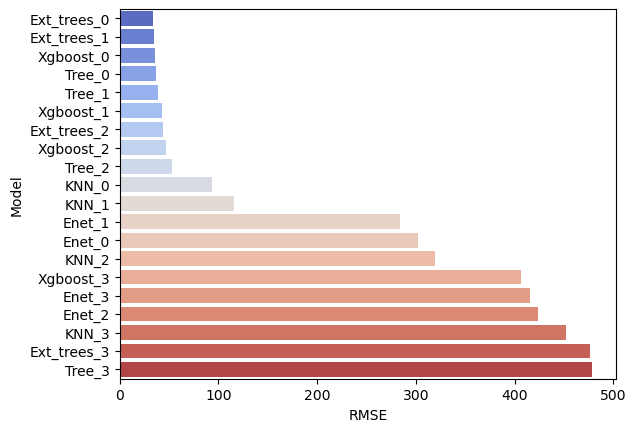

In [531]:
all_metrics = ['MAE','R2','RMSE']


for metric in all_metrics:
    
    temp = metrics.sort_values(by = metric)
    
    plt.figure()
    
    sns.barplot(data = temp, y = 'Model', x = metric, palette = 'coolwarm')

## Training Preprocessor

In [619]:
def winsorize(dataframe):
    
    """Replace any values greater than the band(95th percentile) with the band"""
    
    for column in dataframe:
        
        q95 = dataframe[column].quantile(0.95)
        
        dataframe[column] = np.where(dataframe[column] > q95, q95, dataframe[column])
        
    return dataframe

func_winsorize = FunctionTransformer(winsorize)


In [620]:
# create num pipeline for numerical variables
num_pipeline = Pipeline([
    ('transformer', PowerTransformer(method = 'yeo-johnson')),
    ('scaler', StandardScaler()),  
    ('outliers', func_winsorize),
    ('imputer', SimpleImputer(strategy = 'median')),

])


# create cat pipeline for categorical variables
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
])



# create full preprocessor pipeline
pipeline = ColumnTransformer([
    ('date_transformer', date_pipeline, date_columns),
    ('num_transformer', num_pipeline, num_columns),
    ('cat_transformer', cat_pipeline, cat_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)

In [621]:
# fit preprocessor
xtrain = pipeline.fit_transform(xtrain)
xtest = pipeline.transform(xtest)
xvalidation = pipeline.transform(xvalidation)

In [622]:
xtrain = xtrain[selected_cols_1]
xtest = xtest[selected_cols_1]
xvalidation = xvalidation[selected_cols_1]

## Instantiate  Model for hyperparameter tuning

In [623]:
model = ExtraTreesRegressor()

## Hyperparameter Tuning

In [549]:
search_space = {
    'n_estimators': np.arange(10,200),  # Number of trees in ExtraTreesClassifier
    'max_depth': np.arange(1, 10),       # Maximum depth of trees in ExtraTreesClassifier
    'min_samples_split': np.arange(2, 10),  # Number of boosting rounds in XGBClassifier
    'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],            # Maximum depth of trees in XGBClassifier
    'bootstrap': [True, False]       # Learning rate for XGBClassifier
}

In [550]:
# Perform Bayesian optimization

np.int = int


bayes_search = BayesSearchCV(
    model,
    search_space,
    n_iter=20,               # Number of iterations (adjust as needed)
    scoring='neg_mean_absolute_error',  # Use an appropriate scoring metric
    n_jobs=-1,               # Use all available CPUs
    cv=3,                    # Number of cross-validation folds
    random_state=42
).fit(xvalidation, yvalidation)

In [551]:
bayes_search.best_score_

-141.01823968872313

In [552]:
bayes_search.best_params_

OrderedDict([('bootstrap', True),
             ('max_depth', 5),
             ('min_samples_split', 3),
             ('min_weight_fraction_leaf', 0.1),
             ('n_estimators', 96)])

## Instantiate Ensemble Model for model training

In [633]:
model = ExtraTreesRegressor(**bayes_search.best_params_, ccp_alpha = 0.2)

## Model Training

In [634]:
model.fit(xtrain, ytrain)
train_pred = model.predict(xtrain)

r2 = r2_score(ytrain, train_pred)
mae = mean_absolute_error(ytrain, train_pred)
rmse = np.sqrt(mean_squared_error(ytrain, train_pred))

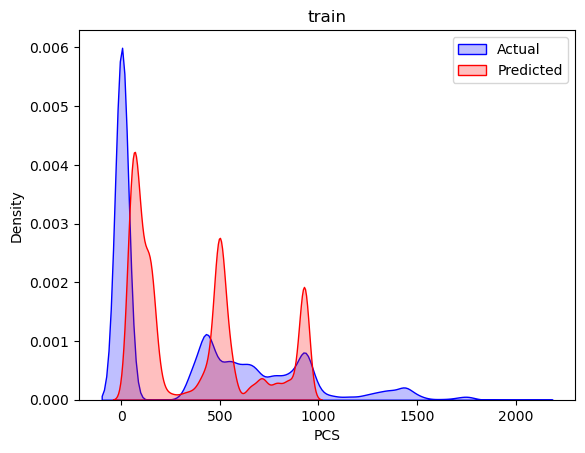

In [635]:
sns.kdeplot(data = ytrain, label = 'Actual', shade = True, color = 'blue')
sns.kdeplot(data = train_pred, label = 'Predicted', shade = True, color = 'red')
plt.legend();plt.title('train');plt.show()

train_metrics =  pd.DataFrame({
    'ensemble_model':'train',
    'R2':r2,
    'MAE':mae,
    'RMSE':rmse,    
}, index = [0])

In [636]:
train_results = pd.DataFrame({
    'Actual':ytrain,
    'Predicted':train_pred
})

train_results['Residuals'] = train_results['Actual'] - train_results['Predicted']
train_results['change_in_%'] = abs((train_results['Residuals']/train_results['Actual'])*100)

train_results.sort_values(by = ['change_in_%'])[:100]

,Actual,Predicted,Residuals,change_in_%
84475,562,562.002121,-0.002121,0.000377
84464,562,562.002121,-0.002121,0.000377
84378,562,562.002121,-0.002121,0.000377
84472,562,562.002121,-0.002121,0.000377
84383,562,562.002121,-0.002121,0.000377
84463,562,562.002121,-0.002121,0.000377
84373,562,562.002121,-0.002121,0.000377
84478,562,562.002121,-0.002121,0.000377
84375,562,562.002121,-0.002121,0.000377
84473,562,562.002121,-0.002121,0.000377


## Model Testing

In [637]:
test_pred = model.predict(xtest)

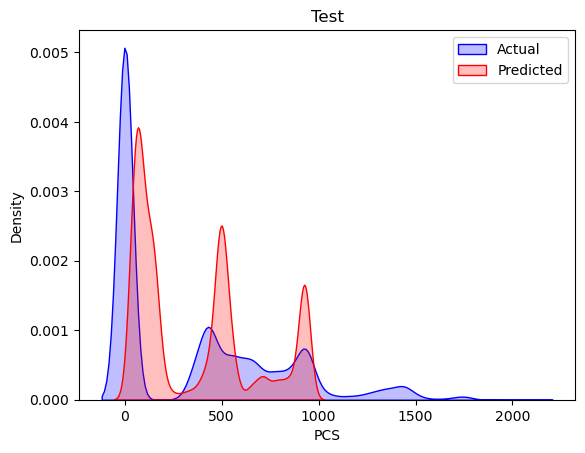

In [638]:
r2 = r2_score(ytest, test_pred)
mae = mean_absolute_error(ytest, test_pred)
rmse = np.sqrt(mean_squared_error(ytest, test_pred))

sns.kdeplot(data = ytest, label = 'Actual', shade = True, color = 'blue')
sns.kdeplot(data = test_pred, label = 'Predicted', shade = True, color = 'red')
plt.legend();plt.title('Test');plt.show()

test_metrics =  pd.DataFrame({
    'ensemble_model':'Test',
    'R2':r2,
    'MAE':mae,
    'RMSE':rmse,    
}, index = [0])

In [639]:
test_results = pd.DataFrame({
    'Actual':ytest,
    'Predicted':test_pred
})

test_results['Residuals'] = test_results['Actual'] - test_results['Predicted']
test_results['change_in_%'] = abs((test_results['Residuals']/test_results['Actual'])*100)

test_results.sort_values(by = ['change_in_%'])[:100]

,Actual,Predicted,Residuals,change_in_%
412924,475,474.998264,0.001736,0.000365
84377,562,562.002121,-0.002121,0.000377
84479,562,562.002121,-0.002121,0.000377
84474,562,562.002121,-0.002121,0.000377
84376,562,562.002121,-0.002121,0.000377
84380,562,562.002121,-0.002121,0.000377
84382,562,562.002121,-0.002121,0.000377
84381,562,562.002121,-0.002121,0.000377
60620,390,389.993484,0.006516,0.001671
60886,390,389.993484,0.006516,0.001671


In [640]:
train_metrics

,ensemble_model,R2,MAE,RMSE
0,train,0.780929,140.194197,199.905082


In [641]:
test_metrics

,ensemble_model,R2,MAE,RMSE
0,Test,0.782217,139.841125,199.087099
